**Customer Relationship Prediction**

---

**Flip-A-Coin**

**Members**:
1. Bhumika Bansal
2. Lakshay Chawla


`The following cell outlines the methodology we followed:`

---

1. Feature Selection
2. Train against different models
3. Results

Discuss more about this

In [ ]:
## Importing the required libraries
## For dealing with data.

import numpy as np
import pandas as pd

## For preparation of data - This includes cleaning the data,feature selection, splitting data into training - testing.

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

# Models to be used.

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

# For interpretation

import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# Comparison Metrics

from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve,f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

In [ ]:
## Read the training data
## Dropping the 1st column as it has newline character
df = pd.read_csv("orange_small_train.data", sep = "\t", lineterminator="\r")
df = df.drop(['Var1'], axis = 1)

y_train_upselling = pd.read_csv("/content/orange_small_train_upselling.labels", sep = "\t", lineterminator="\n", names= ["upselling"])
y_train_appetency = pd.read_csv("/content/orange_small_train_appetency.labels", sep = "\t", lineterminator="\n", names= ["appetency"])
y_train_churn = pd.read_csv("/content/orange_small_train_churn.labels", sep = "\t", lineterminator="\n", names= ["churn"])

Text(0.5, 1.0, 'NaN count by Predictor Variables in the Data')

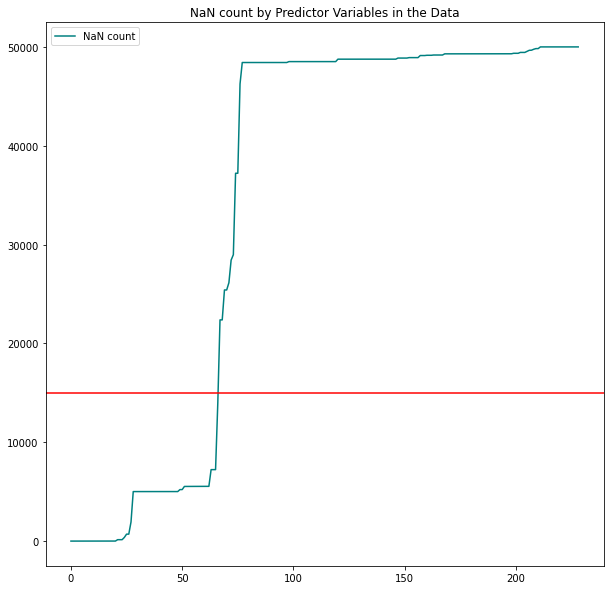

In [ ]:
## Graph showing number of Nan values in each column
nan_count = []
for col in df.columns:
  nan_count.append(df[col].isna().sum())

nan_count.sort()
nan_c = pd.Series(nan_count)
plt.rcParams["figure.figsize"] = (10,10)
nan_c.plot(kind= "line", color = "teal", label = "NaN count")
plt.axhline(15000, c='r')
plt.legend(loc = 'upper left')
plt.title('NaN count by Predictor Variables in the Data')

Text(0.5, 1.0, 'Unique Category Count for Category Variables in the Data')

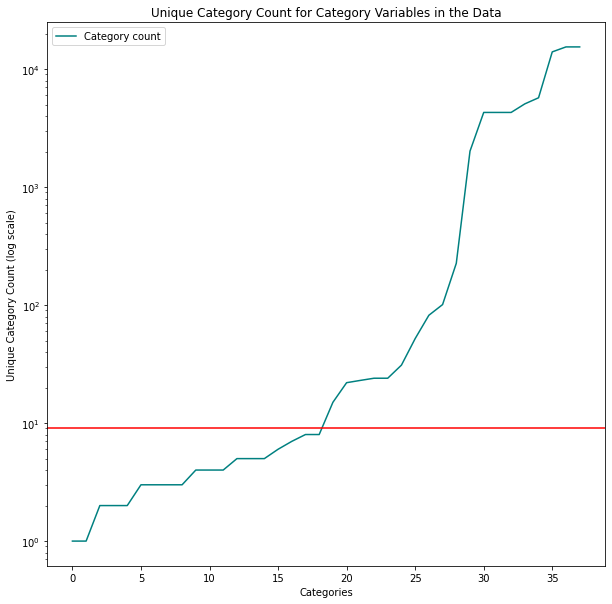

In [ ]:
## Plot showing the unique categories by categorical variables
num_unique_categories = []
for col in df.columns[191:]:
  num_unique_categories.append(len(df[col].unique()))


num_unique_categories.sort()
cat_unique = pd.Series(num_unique_categories)
plt.rcParams["figure.figsize"] = (10,10)
cat_unique.plot(kind= "line", color = "teal", label = "Category count")
plt.yscale('log')
plt.axhline(9, c='r')
plt.xlabel('Categories')
plt.ylabel('Unique Category Count (log scale)')
plt.legend(loc = 'upper left')
plt.title('Unique Category Count for Category Variables in the Data')


In [ ]:
## Several columns have NaN values
## For our purpose, a useful column is one that has fewer than 15000 NaNs
## or 30% NaNs.
def get_useful_columns(data_type):
  useful_cols = []
  
  for col in df.columns:
    nan_count = df[col].isna().sum()
    if df[col].dtypes == data_type and nan_count < 15000:
      if data_type == 'float64':
        useful_cols.append(col)
      elif data_type == 'object' and len(df[col].unique()) < 9:
        useful_cols.append(col)
  
  return useful_cols


In [ ]:
## Impute numerical data as several columns have NaN values
## The default metric is median.
def get_clean_numerical_data(num_cols_list, data_df, metric="median"):
  df_num = data_df[num_cols_list].copy()
  if metric == "median":
    df_num.fillna(df_num.median(),inplace = True)
  elif metric == "mean":
    df_num.fillna(df_num.mean(),inplace = True)

  ## Standardize the values as there are outliers
  scalar = StandardScaler()
  df_std = pd.DataFrame(scalar.fit_transform(df_num),columns = num_cols_list)
  return df_std

In [ ]:
## Preprocessing the categorical columns
useful_cat_cols = get_useful_columns('object')
df_categorical = df[useful_cat_cols].copy()

## 1. Imputing missing values
simple_imputer = SimpleImputer(strategy = "most_frequent")
df_categorical = pd.DataFrame(simple_imputer.fit_transform(df_categorical), columns = useful_cat_cols)


In [ ]:
## Preprocessing the numerical columns
useful_num_cols = get_useful_columns('float64')
df_numerical = get_clean_numerical_data(useful_num_cols, df)

Text(0.5, 1.0, 'Unique response label count for upselling.')

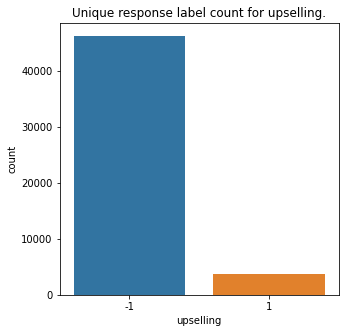

In [ ]:
## Unique response label count for upselling.
plt.rcParams["figure.figsize"] = (5,5)
sns.countplot(x= "upselling", data=y_train_upselling)
plt.title('Unique response label count for upselling.')

Text(0.5, 1.0, 'Unique response label count for appetency.')

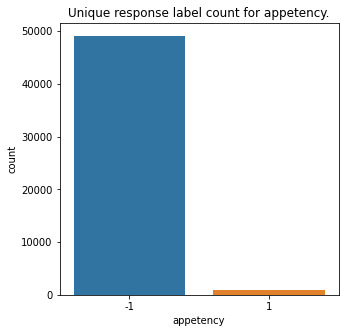

In [ ]:
## Unique response label count for appetency.
plt.rcParams["figure.figsize"] = (5,5)
sns.countplot(x= "appetency", data=y_train_appetency)
plt.title('Unique response label count for appetency.')

Text(0.5, 1.0, 'Unique response label count for churn.')

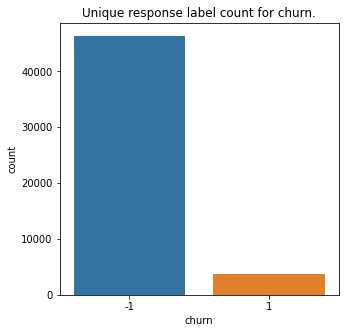

In [ ]:
## Unique response label count for churn.
plt.rcParams["figure.figsize"] = (5,5)
sns.countplot(x= "churn", data=y_train_churn)
plt.title('Unique response label count for churn.')

In [ ]:
## Putting it all together
## Creating the data frame we will be working with
df_train = pd.concat([df_numerical, df_categorical], axis = 1)
df_train = df_train[:-1]
df_train = pd.get_dummies(df_train, columns = useful_cat_cols)


# **Methods**

In [ ]:
## Intersection of lists having Important features from different methods.
def get_feature_intersection(lst1, lst2):
    ans = [value for value in lst1 if value in lst2]
    return ans

In [ ]:
## Splitting the training data as there is no corresponding label file
## for orange_small_test.data
def get_train_test_split(df, y, random_state = 42): 
  x_train, x_test, y_train, y_test = train_test_split(df, 
                                                    y, 
                                                    train_size = 0.80, 
                                                    random_state = random_state,
                                                    stratify = y)
  return x_train, x_test, y_train, y_test

In [ ]:
## Logistic Regression
def get_logistic_regression(X, y):
    random_state = 42
    c_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]
    k = 5
    lreg = LogisticRegression(class_weight= 'balanced', solver = 'lbfgs', random_state = random_state, n_jobs=-1, max_iter = 5000)
    param_grid = {'C': c_list}
    scoring = {'AUC': 'roc_auc'}
    grid_search = GridSearchCV(lreg, 
                                param_grid = param_grid, 
                                scoring = scoring, 
                                refit = 'AUC',
                                return_train_score = True,
                                cv = k,
                                n_jobs = -1)

    results = grid_search.fit(X, y)
    print(results.best_estimator_.get_params())

    ## Get the best estimator
    best_rf = results.best_estimator_
    return best_rf, grid_search

In [ ]:
## Decision Tree
def get_decision_tree(x,y):
  depth_list = [3,6,9,12,15]
  split=[3,4,5,6]
  r_state = 42      
  k=5
  scoring = {'AUC': 'roc_auc'}
  param_grid={'max_depth':depth_list,'min_samples_split':split}

  model=DecisionTreeClassifier(random_state =r_state)

  grid_search = GridSearchCV(model,
                             param_grid = param_grid,
                             scoring = scoring,
                             refit = 'AUC',
                             return_train_score=True,
                             cv=k,
                             n_jobs=-1)
  
  result = grid_search.fit(x,y)
  print(result.best_estimator_.get_params())
  best_rf = result.best_estimator_
  return best_rf, grid_search

In [ ]:
## Vanilla Random Forest
## Return the best RF after grid search
def get_rf_vanilla(X, y):
  seed = 0
  max_depths = [10, 20]
  estimators = [20, 40, 60, 80, 100]

  param_grid = {'n_estimators': estimators, 'max_depth': max_depths}
  scoring = {'AUC': 'roc_auc'}

  random_forest = RandomForestClassifier(n_jobs = -1,
                                        n_estimators = 0,
                                        oob_score=True,
                                        max_features = 'sqrt',
                                        random_state = seed)

  grid_search = GridSearchCV(random_forest, 
                                param_grid = param_grid, 
                                scoring = scoring, 
                                refit = 'AUC',
                                return_train_score = True, 
                                n_jobs = -1)

  results = grid_search.fit(X, y)
  print(results.best_estimator_.get_params())

  ## Get the best estimator
  best_rf = results.best_estimator_
  return best_rf, grid_search

In [ ]:
## Balancing the class imbalance in each bootstrap
## Using the parameters for best tree from grid search for vanilla random forest
def get_rf_balance(X, y):
  random_forest = RandomForestClassifier(n_jobs = -1,
                                        max_depth = 10, 
                                        n_estimators = 100,
                                        oob_score=True,
                                        class_weight = 'balanced_subsample')

  random_forest.fit(X, y)
  return random_forest

## Refit the model with the best parameters, calculate the auc on the test data

In [ ]:
## Balanced Random Forest with SMOTE
## Using the parameters for best tree from grid search for vanilla random forest
def get_rf_smote(X, y):
  sm = SMOTE(random_state = 2)
  X_res, y_res = sm.fit_resample(X, y)

  random_forest = RandomForestClassifier(n_jobs = -1,
                                        max_depth = 10, 
                                        n_estimators = 100,
                                        oob_score=True,
                                        class_weight = 'balanced_subsample')

  random_forest.fit(X_res, y_res)
  return random_forest

## Refit the model with the best parameters, calculate the auc on the test data

In [ ]:
## Balanced Random Forest with RandomUnderSampler.
## Using the parameters for best tree from grid search for vanilla random forest
def get_rf_downsampler(X, y):
  rf = RandomUnderSampler(random_state = 2)
  X_res, y_res = rf.fit_resample(X, y)

  random_forest = RandomForestClassifier(n_jobs = -1,
                                        max_depth = 10, 
                                        n_estimators = 100,
                                        oob_score=True,
                                        class_weight = 'balanced_subsample')

  random_forest.fit(X_res, y_res)
  return random_forest

## Refit the model with the best parameters, calculate the auc on the test data

In [ ]:
## AdaBoost
## Return the best estimator after grid search
def get_adaboost(X, y, refit = 'AUC'):
  boost = AdaBoostClassifier( base_estimator = DecisionTreeClassifier(max_depth = 1), 
                              algorithm = 'SAMME', n_estimators=0)
  learning_rates = [1e-2, 1e-1, 1, 10]
  estimators = [20, 40, 60, 80, 100]
  scoring = {'AUC': 'roc_auc',  'PREC': 'precision', 'RECALL': 'recall'}

  param_grid = {'n_estimators': estimators, 'learning_rate': learning_rates}
  grid_search = GridSearchCV(boost, 
                                param_grid = param_grid, 
                                scoring = scoring, 
                                refit = refit,
                                return_train_score = True, 
                                n_jobs = -1)

  results = grid_search.fit(X, y)
  print(results.best_estimator_.get_params())

  ## Get the best estimator
  best_rf = results.best_estimator_
  return best_rf, grid_search


In [ ]:
## Get all the comparison metrics.
def get_metrics(predictions, labels, probabilities):
  ## Calculating the metrics.
  metrics = {}
  metrics["accuracy"] = accuracy_score(labels, predictions)
  metrics["recall"] = recall_score(labels, predictions)
  metrics["precision"] = precision_score(labels, predictions)
  metrics["f1_score"] = f1_score(labels, predictions)
  metrics["auc_score"] = roc_auc_score(labels, probabilities[:, 1])
  return metrics


In [ ]:
## Print the metrics for all the models in a pretty table.
def print_metrics(metrics_dict):
  pt = PrettyTable()
  pt.field_names = ["Model Name","Accuracy","Recall","Precision","F1 Score","AUC score"]
  for i in metrics_dict.keys():
    pt.add_row([i,metrics_dict[i]['accuracy'],metrics_dict[i]['recall'],metrics_dict[i]['precision'],metrics_dict[i]['f1_score'],metrics_dict[i]['auc_score']])
  print(pt)

In [ ]:
## Get the permutation importance
def get_permutation_importance(model, x, y, ff, metric):
  ## Calculate the Permutation importance
  r = permutation_importance(model, x, y,
                              n_repeats=30,
                              random_state=0, scoring = metric)

  for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
      print(f"{ff[i]:<8}"
                f"{r.importances_mean[i]:.3f}"
                f" +/- {r.importances_std[i]:.3f}")

In [ ]:
## Code to plot confusion matrix
def get_confusion_matrix(y_orig, y_pred, classes):
  plt.rcParams["figure.figsize"] = (10,10)
  conf_matrix = confusion_matrix(y_orig, y_pred)
  conf_matrix_plot = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = classes)
  conf_matrix_plot.plot()
  return conf_matrix


In [ ]:
## Getting ROC-AUC curve
def get_roc_curve(model, testX, testy, name):
    plt.rcParams["figure.figsize"] = (10,10)
    y_probs = model.predict_proba(testX)[:,1]
    fpr,tpr,threshold = roc_curve(testy,y_probs)
    plt.plot(fpr,tpr,color = 'red')
    plt.plot([0, 1], [0, 1],'r--',color = 'blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for {name}.')
    plt.legend(loc="lower right")
    return fpr,tpr

# **Predicting Upselling**

In [ ]:
## Get the test train split with Upselling data
x_train, x_test, y_train, y_test = get_train_test_split(df_train, y_train_upselling)

# **Feature Selection**
We have 81 columns. We try to find the most useful columns from these based on:
1. Information gain
2. Random Forest Feature Importance

## **Information gain**

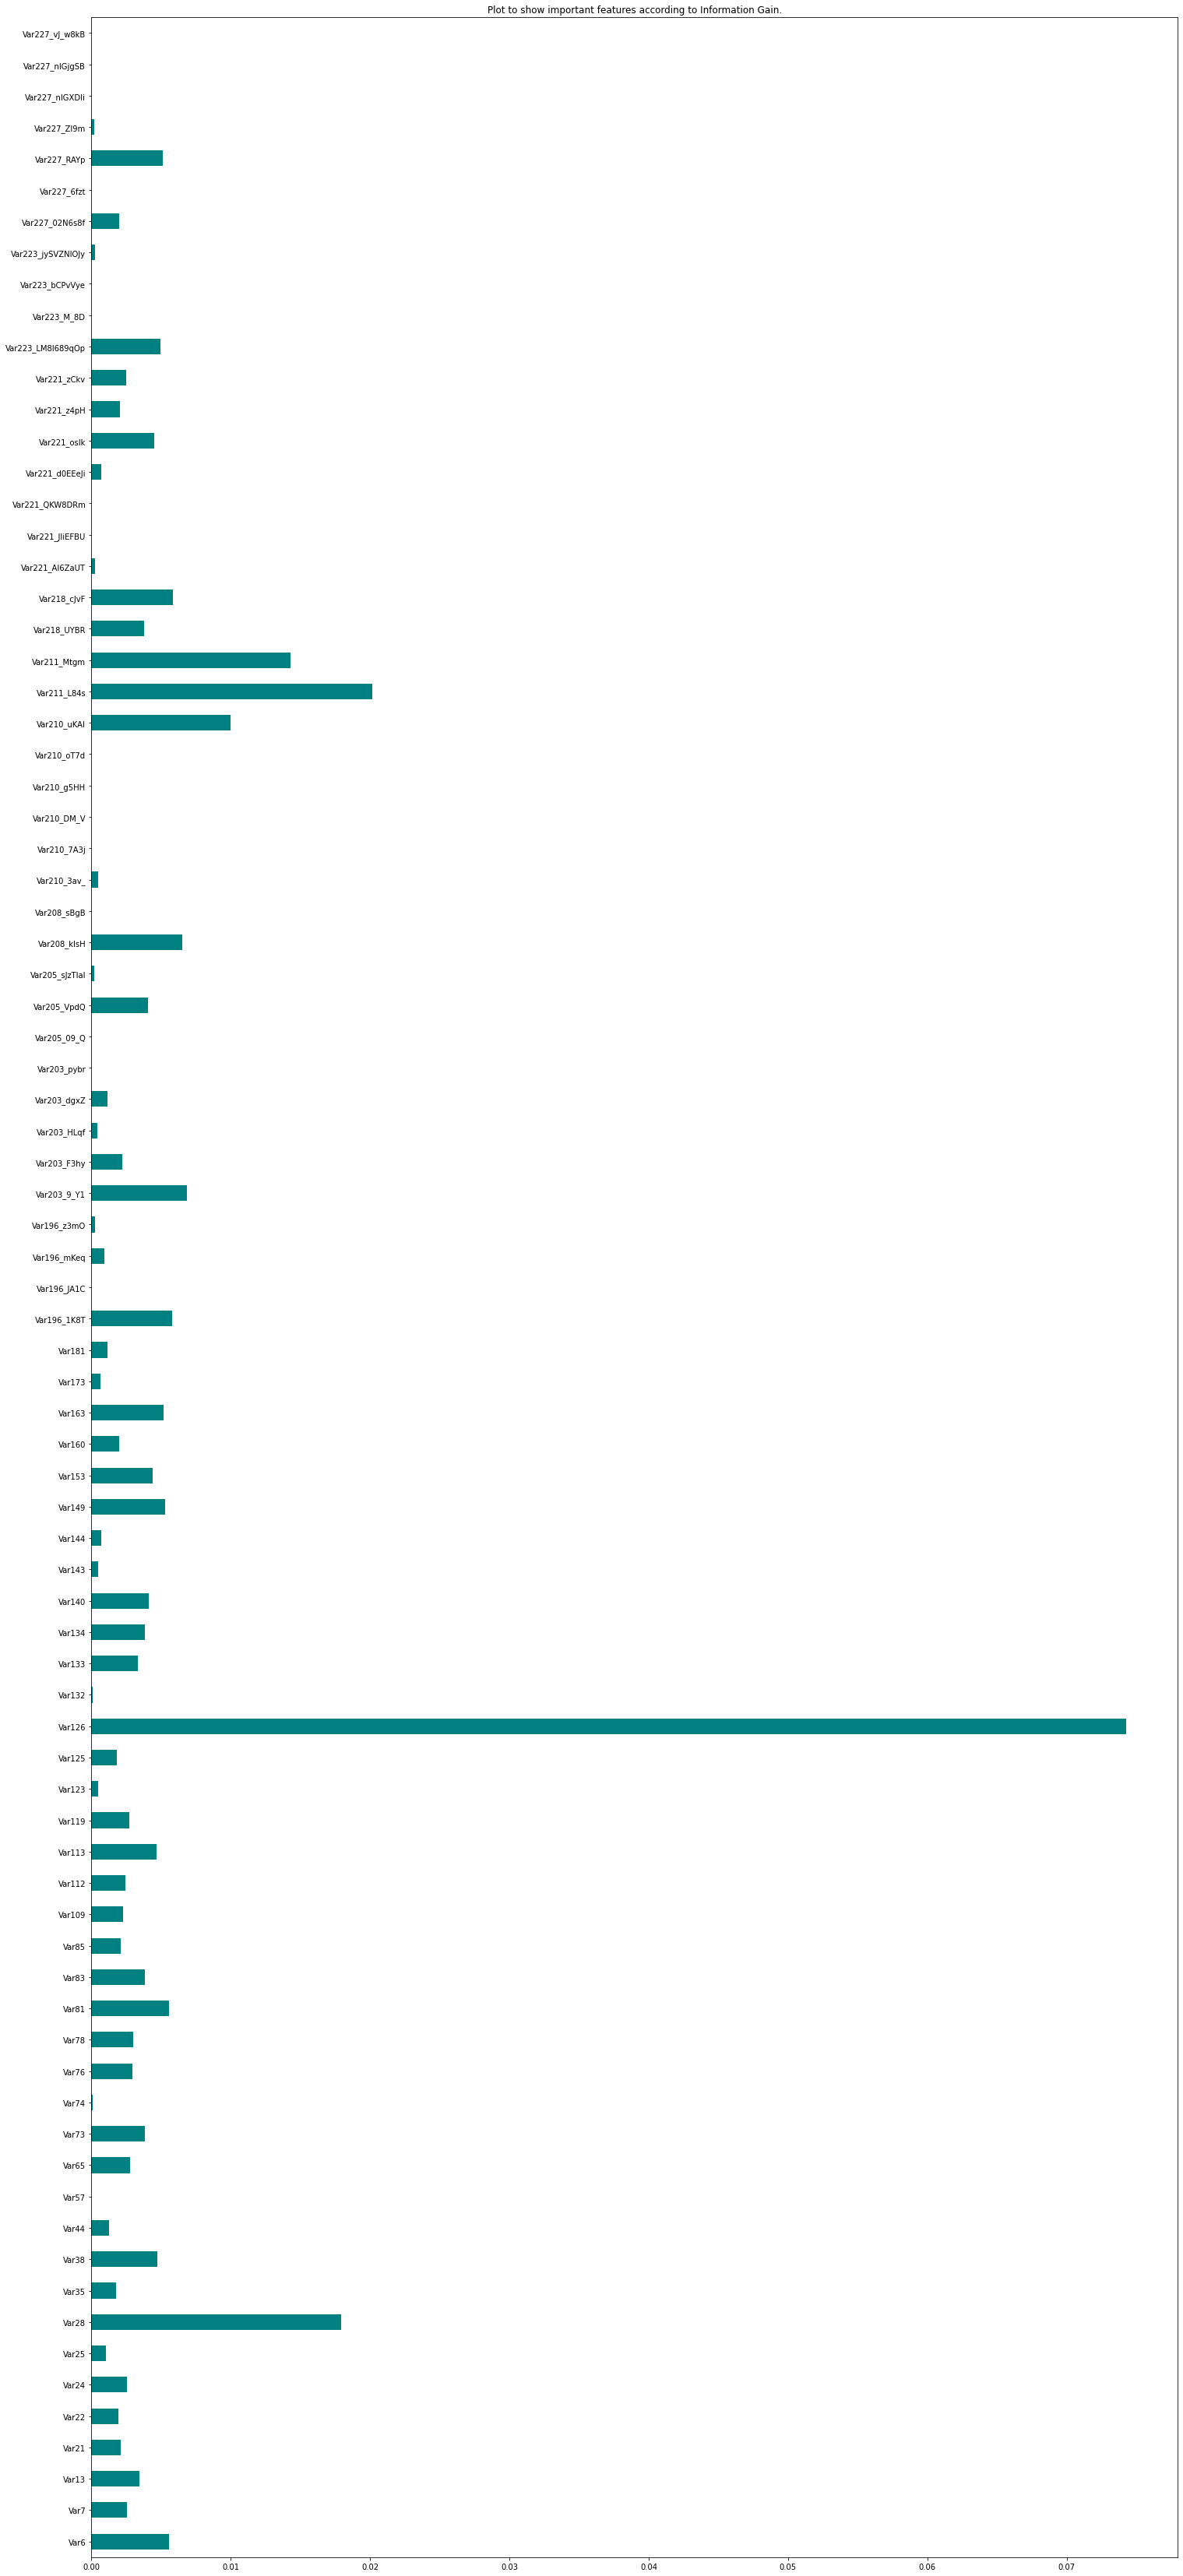

In [ ]:
## Finding important features using information gain.
ig_importances = mutual_info_classif(x_train, y_train.values.ravel())
feat_importances = pd.Series(ig_importances, df_train.columns)

## Plot to show important features according to Information Gain.
plt.rcParams["figure.figsize"] = (25,60)
feat_importances.plot(kind= "barh", color = "teal")
plt.title('Plot to show important features according to Information Gain.')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Boxplot of important features according to Information Gain.')

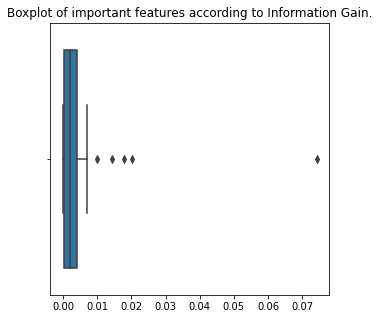

In [ ]:
## Boxplot of important features according to Information Gain.
plt.rcParams["figure.figsize"] = (5,5)
sns.boxplot(feat_importances).set_title('Boxplot of important features according to Information Gain.')

In [ ]:
## Removing 25% of least important features.
ft_ig = feat_importances[feat_importances >= feat_importances.quantile(0.25)].index.tolist()

Random Forest Feature Importance and Feature Selection

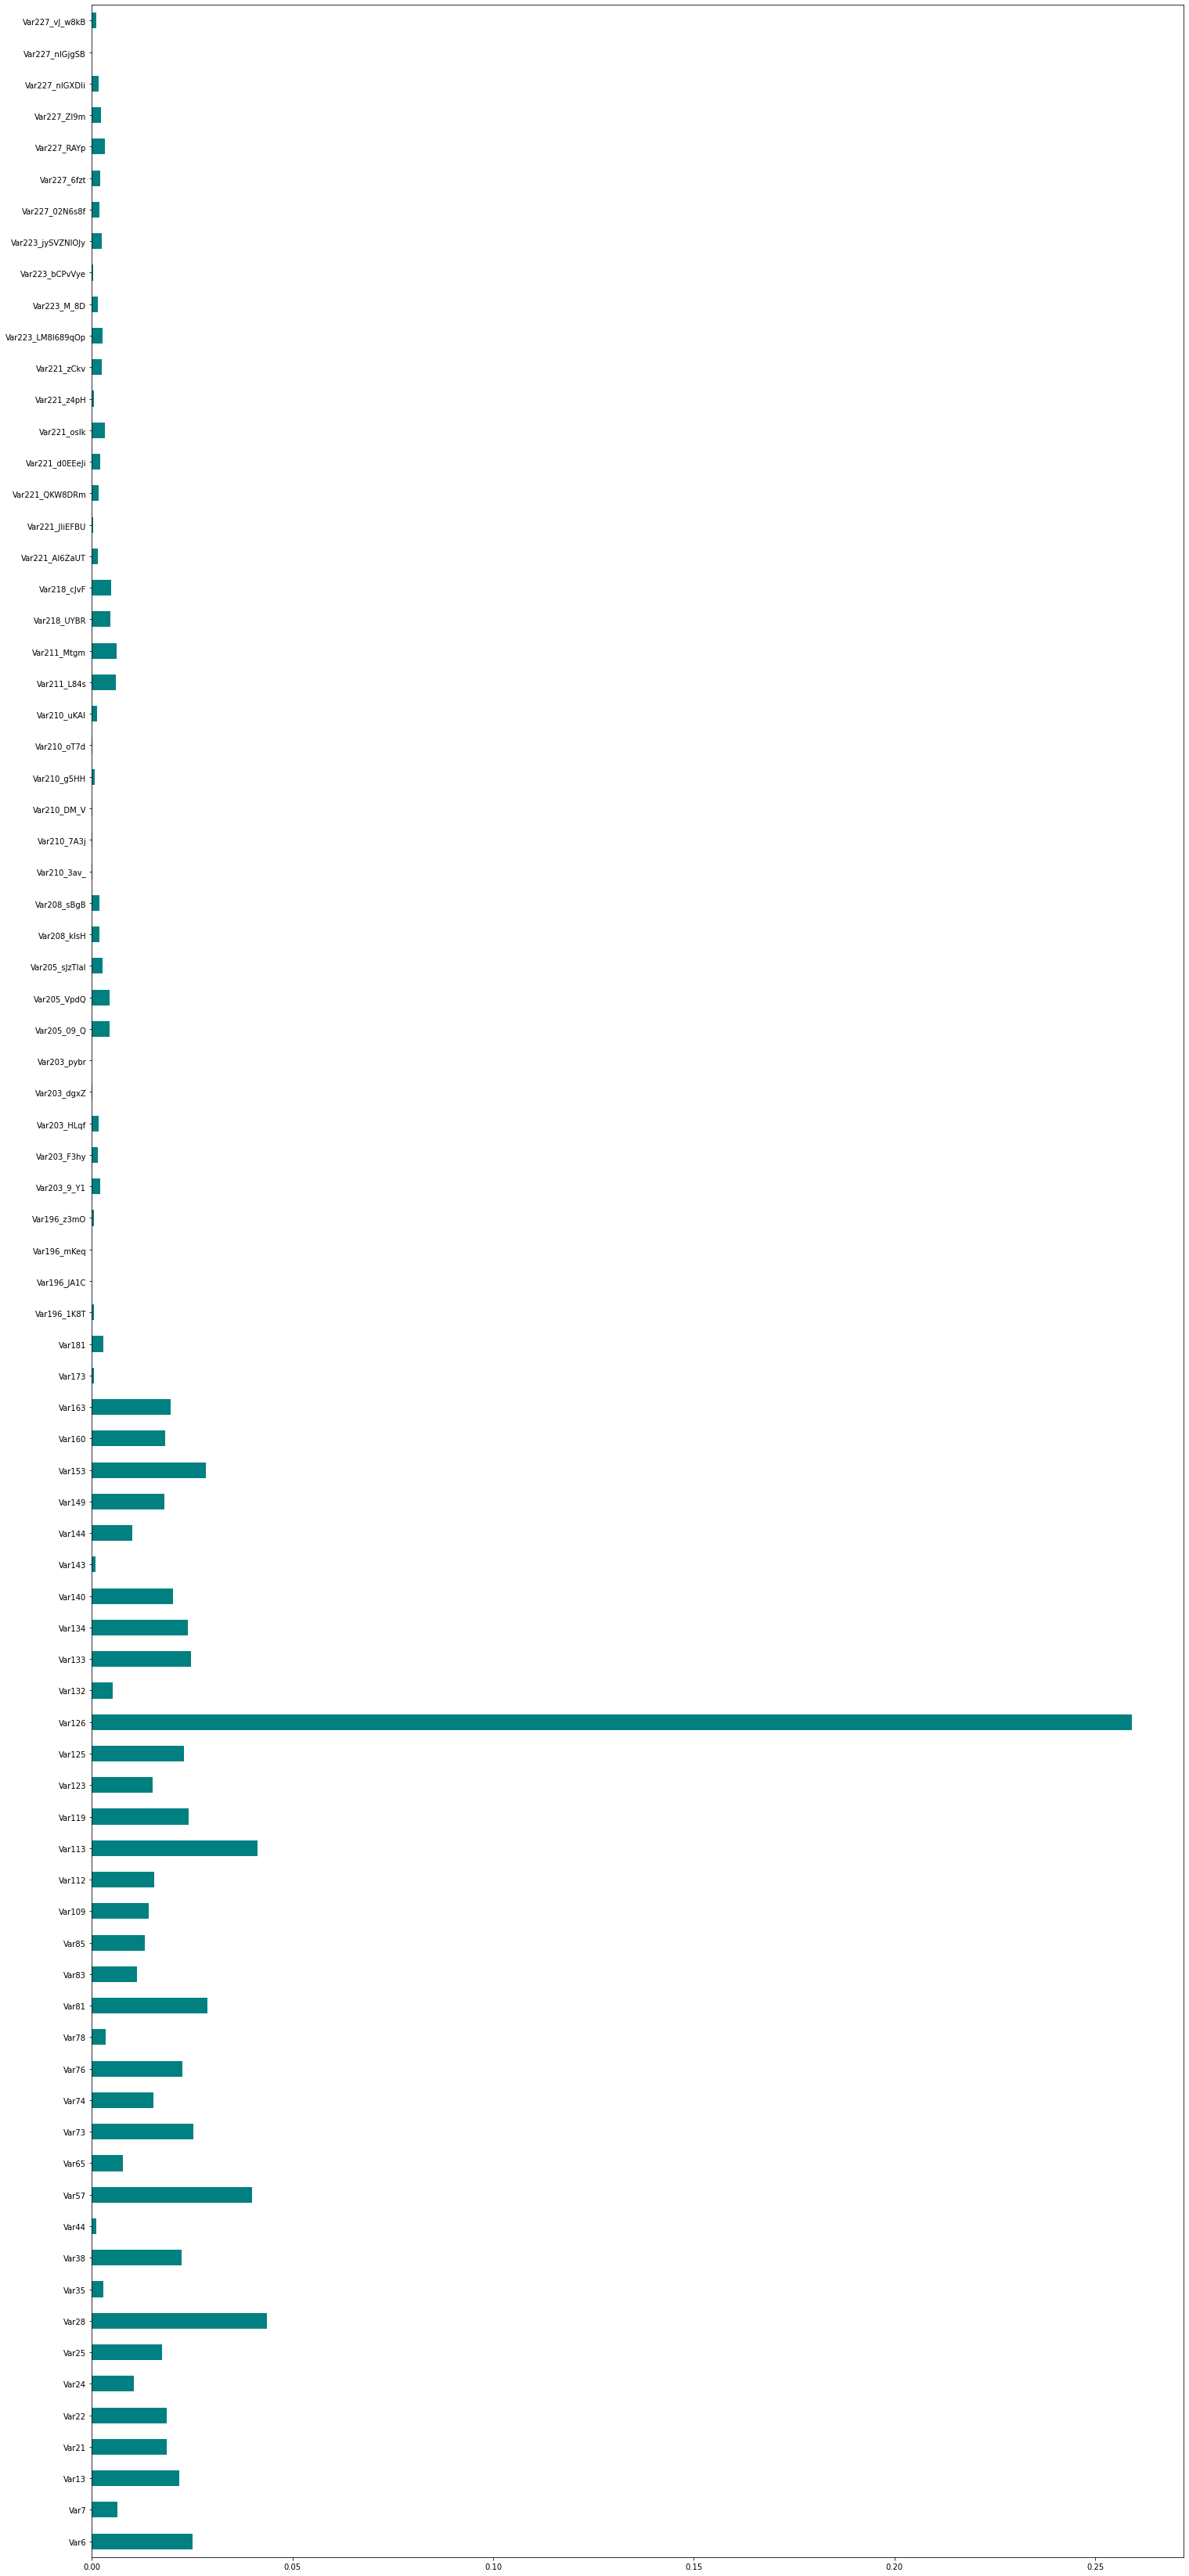

In [ ]:
## Finding important features using Random Forest Feature Selection.
rf_feat_select = RandomForestClassifier(n_estimators=340)
rf_feat_select.fit(x_train, y_train.values.ravel())
rf_imp = rf_feat_select.feature_importances_
rf_importance = pd.Series(rf_imp, df_train.columns)

## Plot to show important features according to Random Forest Feature Selection.
plt.rcParams["figure.figsize"] = (25,60)
rf_importance.plot(kind= "barh", color = "teal")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


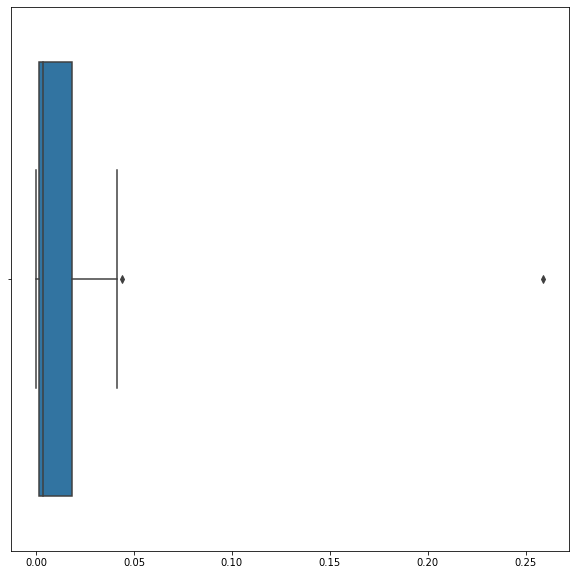

In [ ]:
## Boxplot of important features according to Random Forest Feature Selection.
plt.rcParams["figure.figsize"] = (5,5)
sns.boxplot(rf_importance)

In [ ]:
## Removing 25% of least important features.
ft_rf = rf_importance[rf_importance >= rf_importance.quantile(0.25)].index.tolist()

In [ ]:
## Using the intersection function to get the final list of important features.
final_features = get_feature_intersection(ft_rf, ft_ig)

# **Model**

In [ ]:
## Select only the important features in x_train and x_test.
x_train = pd.DataFrame(x_train, columns=df_train.columns)
x_test = pd.DataFrame(x_test, columns=df_train.columns)

x_train = x_train[final_features].values
x_test = x_test[final_features].values


In [ ]:
## The dictionaries hold metrics, confusion matrix data, and ROC-AUC curve information
## for all the models
final_result_upselling = {}
conf_matrix_upselling = {}
roc_upselling = {}

{'C': 10.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 5000, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


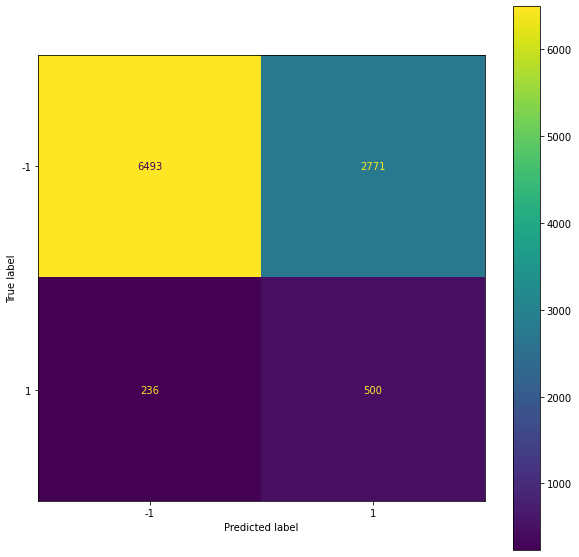

In [ ]:
## Linear Regression model
lreg, gs_lreg = get_logistic_regression(x_train, y_train.values.ravel())
predictions = lreg.predict(x_test)
probabilities = lreg.predict_proba(x_test)
final_result_upselling["logic_reg"] = get_metrics(predictions, y_test.values.ravel(), probabilities)

conf_matrix_upselling["logic_reg"] = get_confusion_matrix(y_test, predictions, lreg.classes_)

No handles with labels found to put in legend.


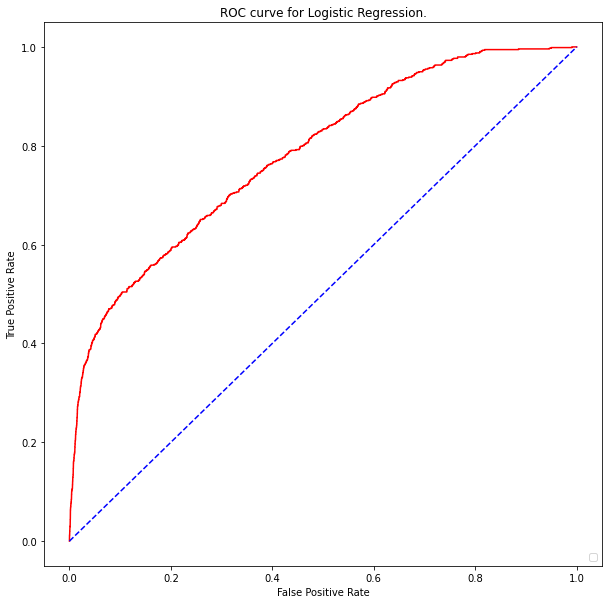

In [ ]:
## ROC Curve for Logistic Regression.
roc_upselling["logic_reg"] = get_roc_curve(lreg, x_test, y_test, "Logistic Regression")

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


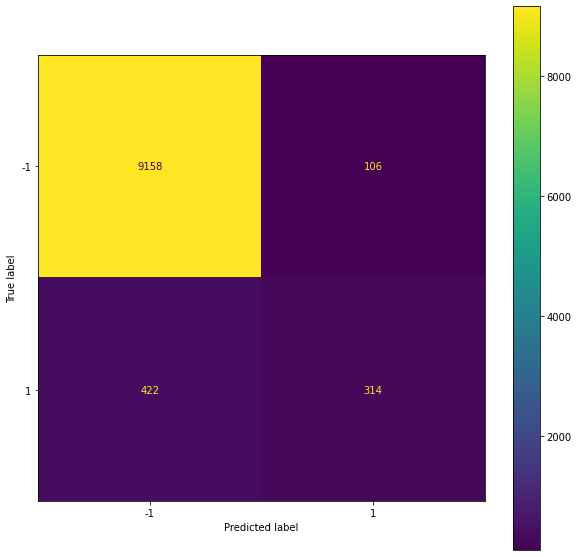

In [ ]:
## Decision Tree Model.
dst, gs_dst = get_decision_tree(x_train, y_train.values.ravel())
predictions = dst.predict(x_test)
probabilities = dst.predict_proba(x_test)
final_result_upselling["decision_tree"] = get_metrics(predictions, y_test.values.ravel(), probabilities)

conf_matrix_upselling["decision_tree"] = get_confusion_matrix(y_test, predictions, dst.classes_)

No handles with labels found to put in legend.


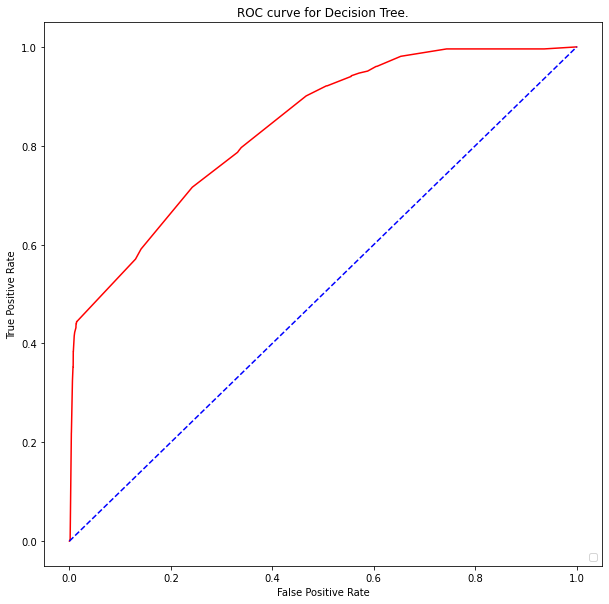

In [ ]:
## ROC Curve for Decision Tree.
roc_upselling["decision_tree"] = get_roc_curve(dst, x_test, y_test, "Decision Tree")

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 0, 'verbose': 0, 'warm_start': False}


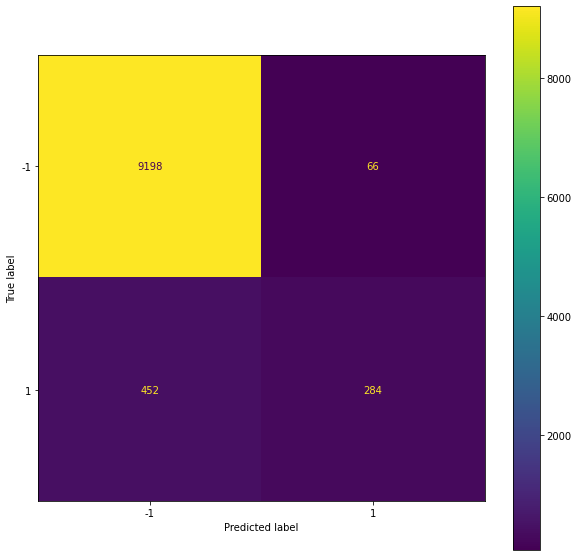

In [ ]:
## Vanilla Random Forest Model
rfv, gs_rfv = get_rf_vanilla(x_train, y_train.values.ravel())
predictions = rfv.predict(x_test)
probabilities = rfv.predict_proba(x_test)
final_result_upselling["vanilla_random_forest"] = get_metrics(predictions, y_test.values.ravel(), probabilities)

conf_matrix_upselling["vanilla_random_forest"] = get_confusion_matrix(y_test, predictions, rfv.classes_)

No handles with labels found to put in legend.


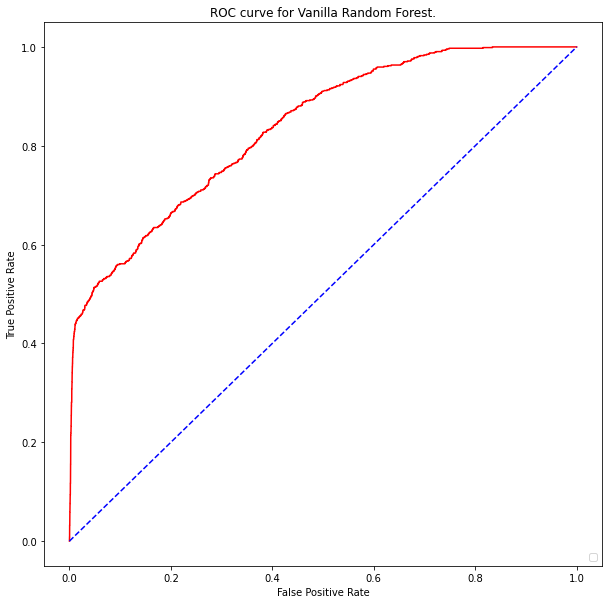

In [ ]:
## ROC Curve for vanilla random forest.
roc_upselling["vanilla_random_forest"] = get_roc_curve(rfv, x_test, y_test, "Vanilla Random Forest")

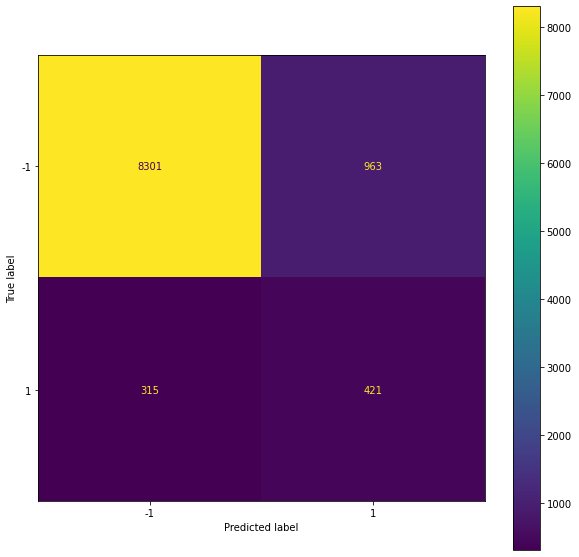

In [ ]:
## Balanced Random Forest Model.
rf_balance = get_rf_balance(x_train, y_train.values.ravel())
predictions = rf_balance.predict(x_test)
probabilities = rf_balance.predict_proba(x_test)
final_result_upselling["rf_balanced"] = get_metrics(predictions, y_test.values.ravel(), probabilities)

conf_matrix_upselling["rf_balanced"] = get_confusion_matrix(y_test, predictions, rf_balance.classes_)

No handles with labels found to put in legend.


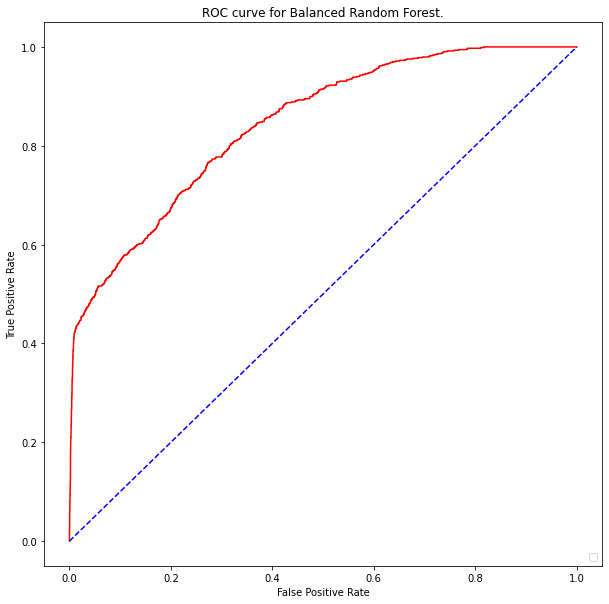

In [ ]:
## ROC Curve for balanced random forest.
roc_upselling["rf_balanced"] = get_roc_curve(rf_balance, x_test, y_test, "Balanced Random Forest")

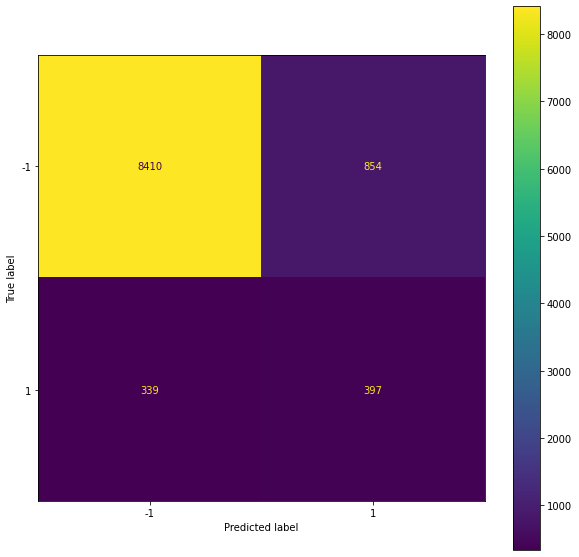

In [ ]:
## Random Forest model with smote upsampling.
rf_smote = get_rf_smote(x_train, y_train.values.ravel())
predictions = rf_smote.predict(x_test)
probabilities = rf_smote.predict_proba(x_test)
final_result_upselling["rf_smote"] = get_metrics(predictions, y_test.values.ravel(), probabilities)

conf_matrix_upselling["rf_smote"] = get_confusion_matrix(y_test, predictions, rf_smote.classes_)

No handles with labels found to put in legend.


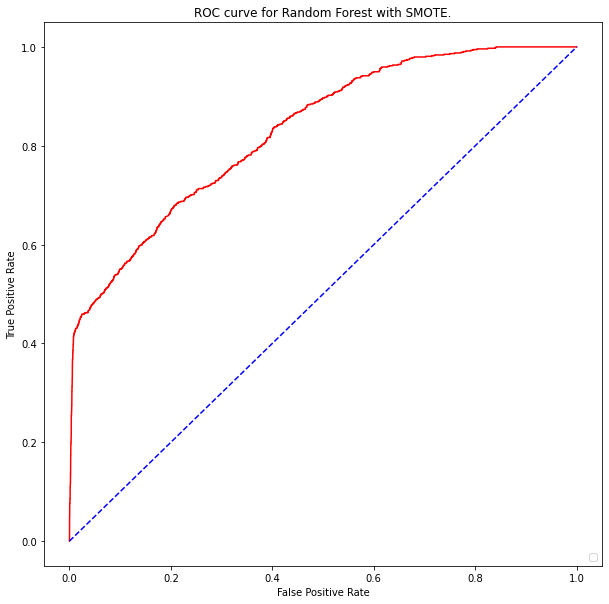

In [ ]:
## ROC Curve for Random Forest model with smote upsampling.
roc_upselling["rf_smote"] = get_roc_curve(rf_smote, x_test, y_test, "Random Forest with SMOTE")

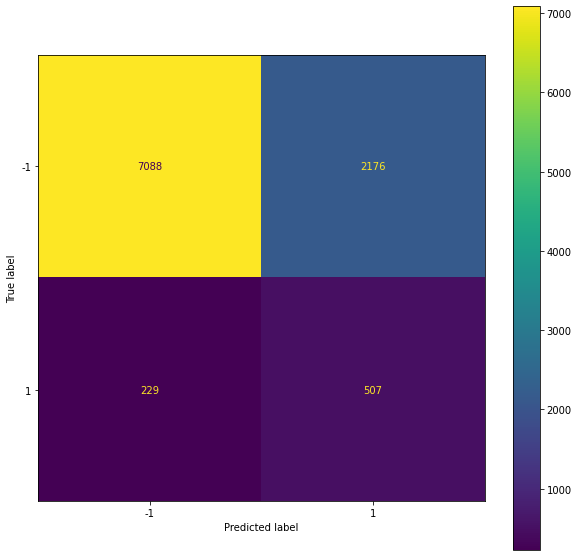

In [ ]:
# Random Forest model with downsampling.
rf_d = get_rf_downsampler(x_train, y_train.values.ravel())
predictions = rf_d.predict(x_test)
probabilities = rf_d.predict_proba(x_test)
final_result_upselling["rf_down"] = get_metrics(predictions, y_test.values.ravel(), probabilities)

conf_matrix_upselling["rf_down"] = get_confusion_matrix(y_test, predictions, rf_d.classes_)

No handles with labels found to put in legend.


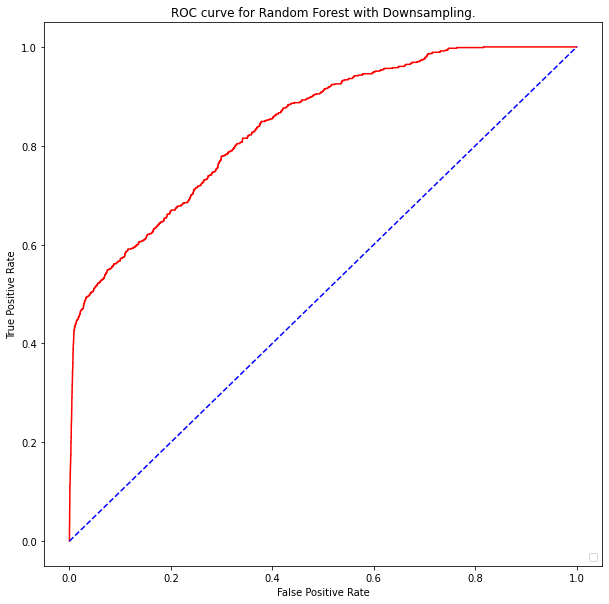

In [ ]:
## ROC Curve for Random Forest model with downsampling.
roc_upselling["rf_down"] = get_roc_curve(rf_d, x_test, y_test, "Random Forest with Downsampling")

{'algorithm': 'SAMME', 'base_estimator__ccp_alpha': 0.0, 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 1, 'n_estimators': 100, 'random_state': None}


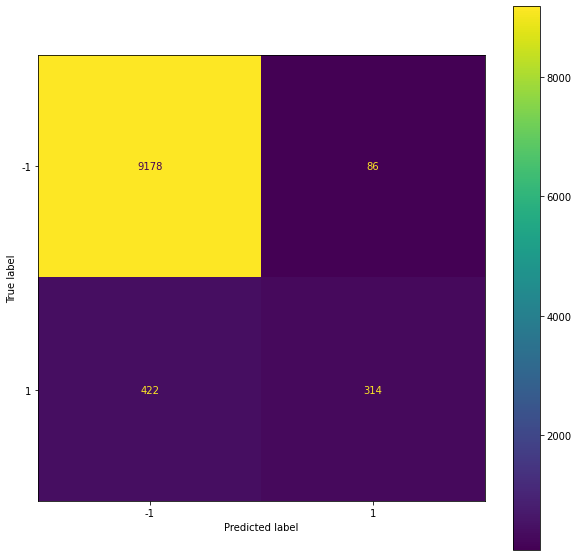

In [ ]:
## Adaboost model
ada, gs_ada = get_adaboost(x_train, y_train.values.ravel())
predictions = ada.predict(x_test)
probabilities = ada.predict_proba(x_test)
final_result_upselling["adaboost"] = get_metrics(predictions, y_test.values.ravel(), probabilities)

conf_matrix_upselling["adaboost"] = get_confusion_matrix(y_test, predictions, ada.classes_)

No handles with labels found to put in legend.


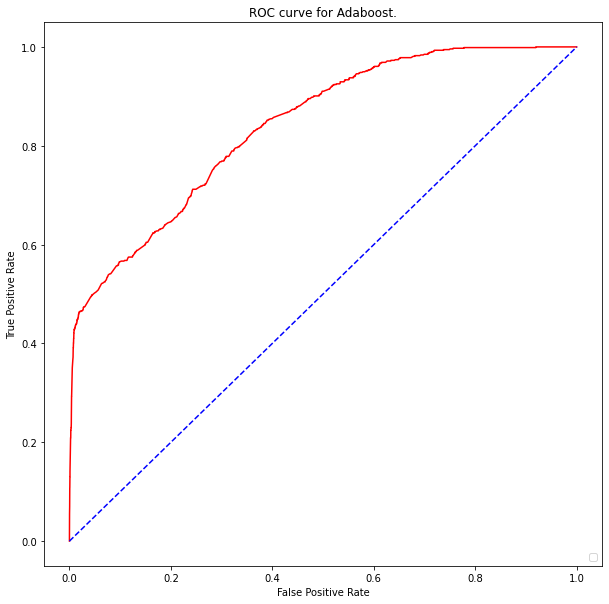

In [ ]:
## ROC Curve for adaboost model.
roc_upselling["adaboost"] = get_roc_curve(ada, x_test, y_test, "Adaboost")

In [ ]:
## Printing the comparison metrics.
print_metrics(final_result_upselling)

+-----------------------+----------+--------------------+---------------------+---------------------+--------------------+
|       Model Name      | Accuracy |       Recall       |      Precision      |       F1 Score      |     AUC score      |
+-----------------------+----------+--------------------+---------------------+---------------------+--------------------+
|       logic_reg       |  0.6993  | 0.6793478260869565 |  0.1528584530724549 | 0.24956326428749687 | 0.7830225815686715 |
|     decision_tree     |  0.9472  | 0.4266304347826087 |  0.7476190476190476 |  0.5432525951557093 | 0.8373567679000525 |
| vanilla_random_forest |  0.9482  | 0.3858695652173913 |  0.8114285714285714 |  0.5230202578268877 | 0.8358672479255838 |
|      rf_balanced      |  0.8722  | 0.5720108695652174 |  0.3041907514450867 | 0.39716981132075474 | 0.843826411964031  |
|        rf_smote       |  0.8807  | 0.5394021739130435 |  0.3173461231015188 | 0.39959738298943126 | 0.8301659034270106 |
|        rf_down

In [ ]:
## The permutation importance for rf_down
get_permutation_importance(rf_balance, x_test, y_test, final_features)

Var126  0.025 +/- 0.002


**Predicting Appetancy**

In [ ]:
## Splitting the training data as there is no corresponding label file
## for orange_small_test.data
## Get the test train split with Upselling data
x_train, x_test, y_train, y_test = get_train_test_split(df_train, y_train_appetency, 28)

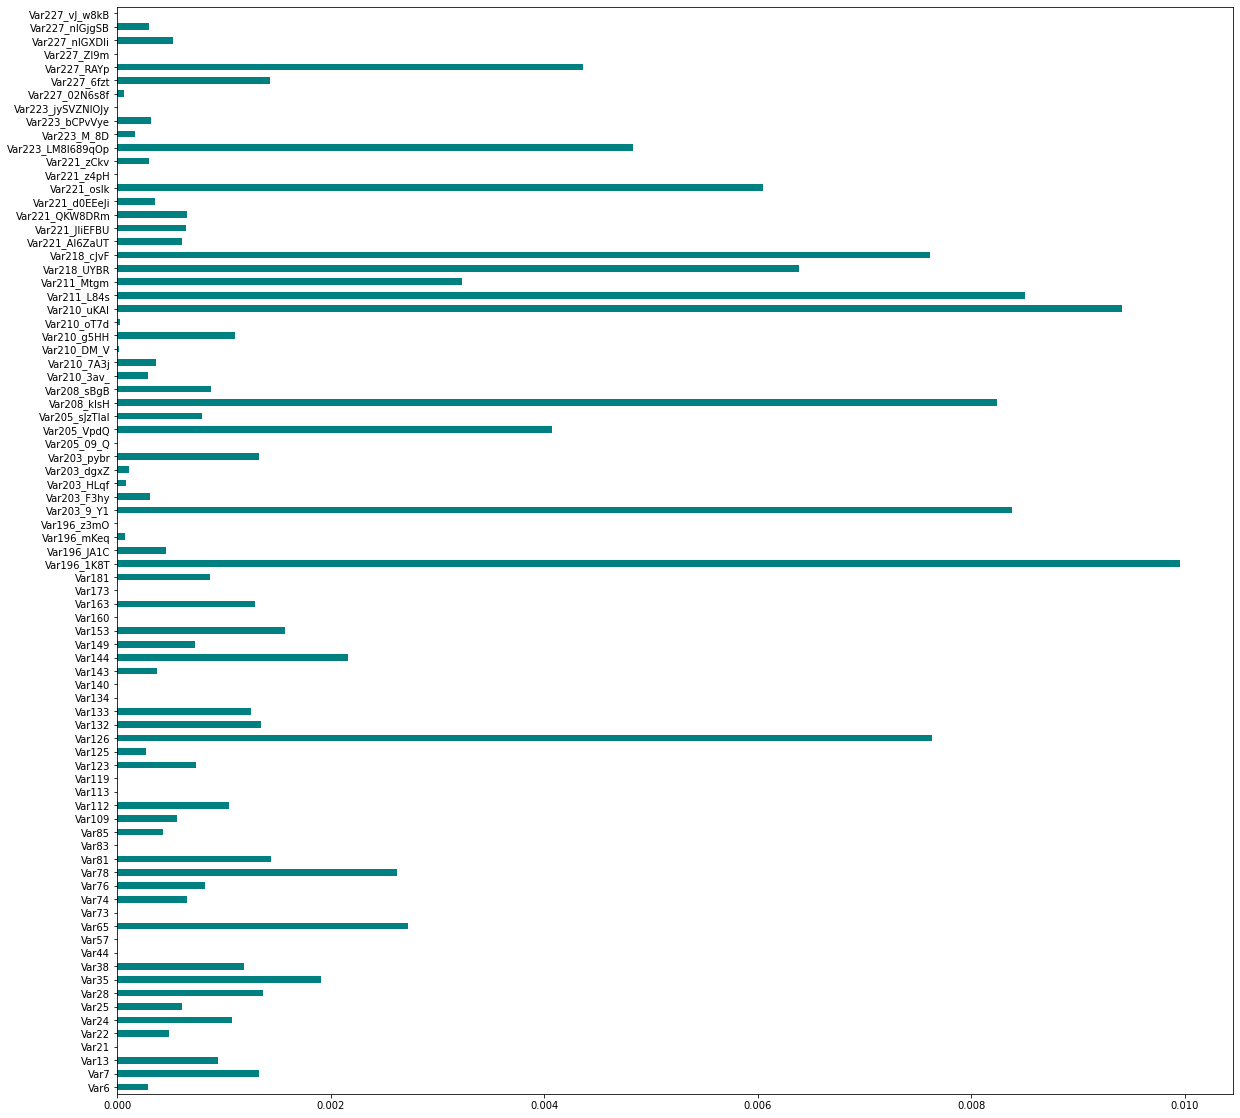

In [ ]:
## Finding important features using information gain.
ig_importances = mutual_info_classif(x_train, y_train.values.ravel())
feat_importances = pd.Series(ig_importances, df_train.columns)
ft_ig = feat_importances[feat_importances >= feat_importances.quantile(0.25)].index.tolist()

## Plot to show important features according to Information Gain.
plt.rcParams["figure.figsize"] = (20,20)
feat_importances.plot(kind= "barh", color = "teal")

plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


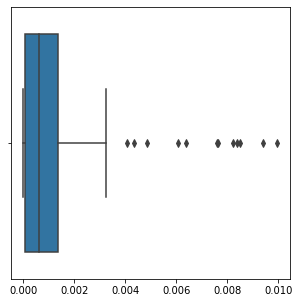

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)
sns.boxplot(feat_importances)

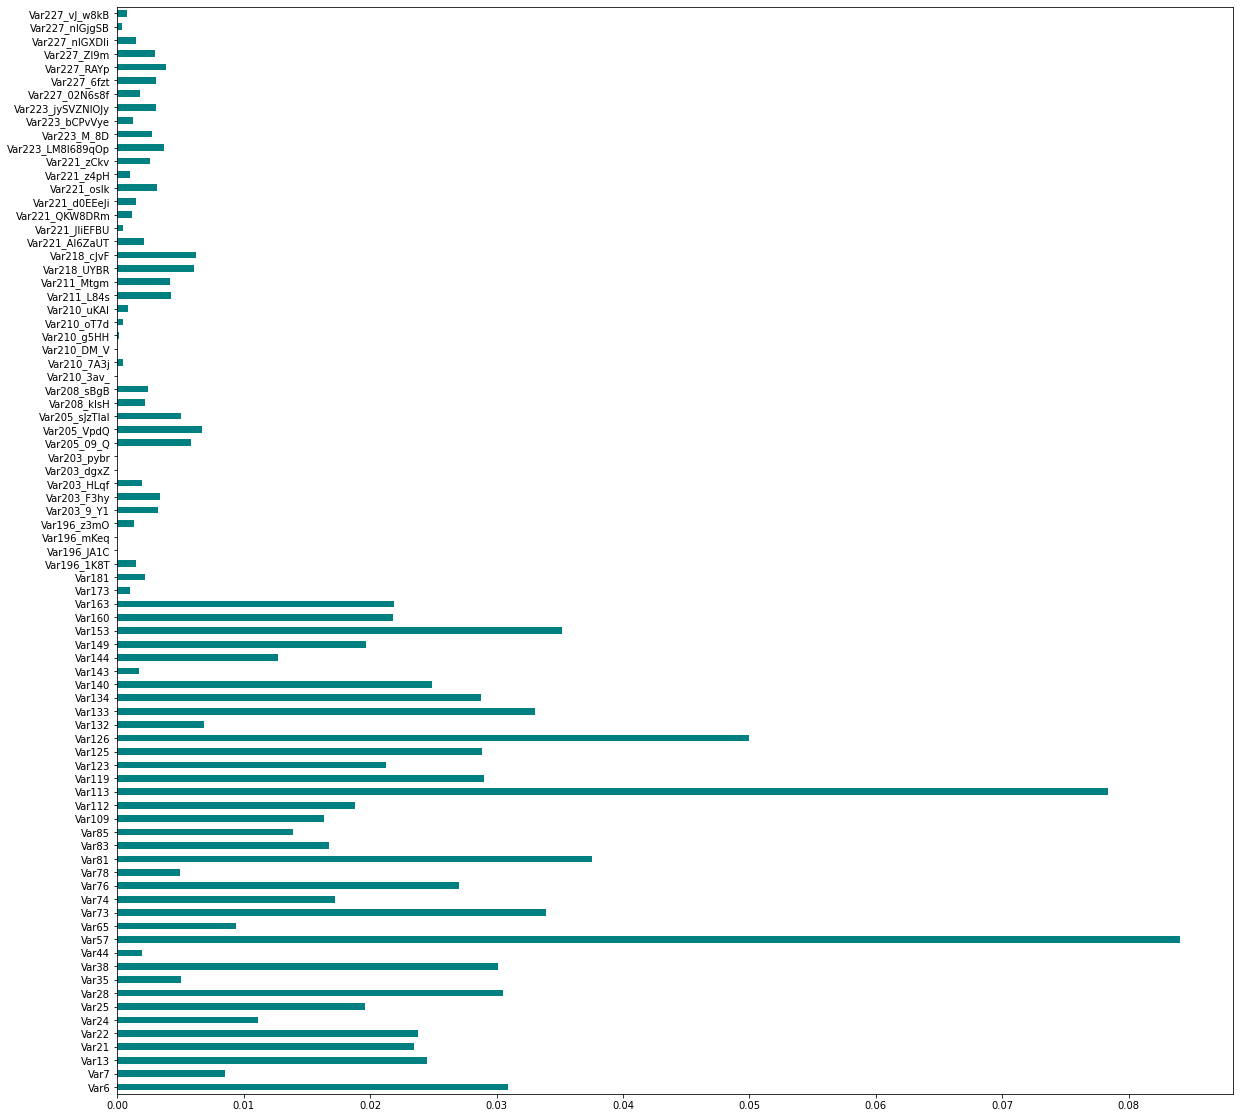

In [ ]:
## Finding important features using Random Forest Feature Selection.
rf_feat_select = RandomForestClassifier(n_estimators=340)
rf_feat_select.fit(x_train, y_train.values.ravel())
rf_imp = rf_feat_select.feature_importances_
rf_importance = pd.Series(rf_imp, df_train.columns)

# Select all features above the 25th percentile
ft_rf = rf_importance[rf_importance >= rf_importance.quantile(0.25)].index.tolist()

plt.rcParams["figure.figsize"] = (20,20)
rf_importance.plot(kind= "barh", color = "teal")
plt.show()

In [ ]:
## Get the final list of important features based on Information Gain and RF importance
final_features = get_feature_intersection(ft_ig, ft_rf)

In [ ]:
## Reset the data frames based on the new final features
x_train = pd.DataFrame(x_train, columns=df_train.columns)
x_test = pd.DataFrame(x_test, columns=df_train.columns)

x_train = x_train[final_features].values
x_test = x_test[final_features].values

final_result_appetency = {}
conf_matrix_appetency = {}
roc_appetency = {}

{'C': 0.001, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 5000, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


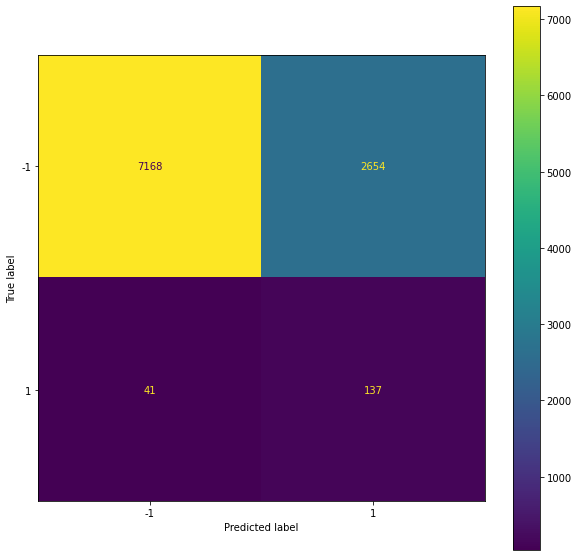

In [ ]:
## Logistic Regression
lreg, gs_lreg = get_logistic_regression(x_train, y_train.values.ravel())
predictions = lreg.predict(x_test)
probabilities = lreg.predict_proba(x_test)
final_result_appetency["logic_reg"] = get_metrics(predictions, y_test.values.ravel(), probabilities)

conf_matrix_appetency["logic_reg"] = get_confusion_matrix(y_test, predictions, lreg.classes_)

No handles with labels found to put in legend.


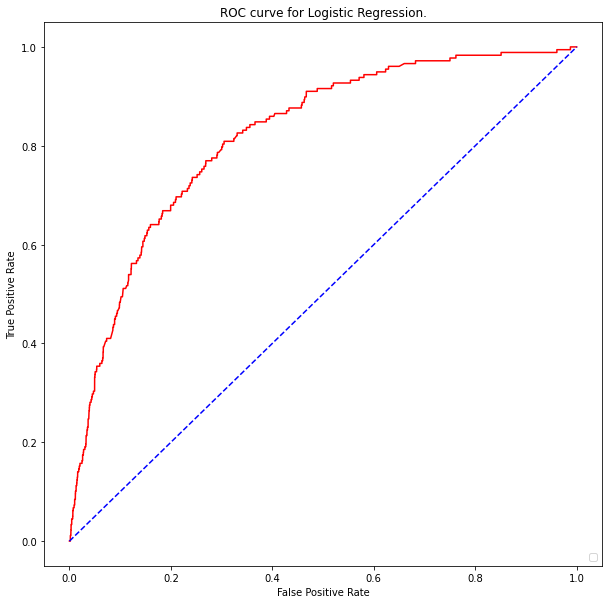

In [ ]:
## ROC Curve
roc_appetency["logic_reg"] = get_roc_curve(lreg, x_test, y_test, "Logistic Regression")

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


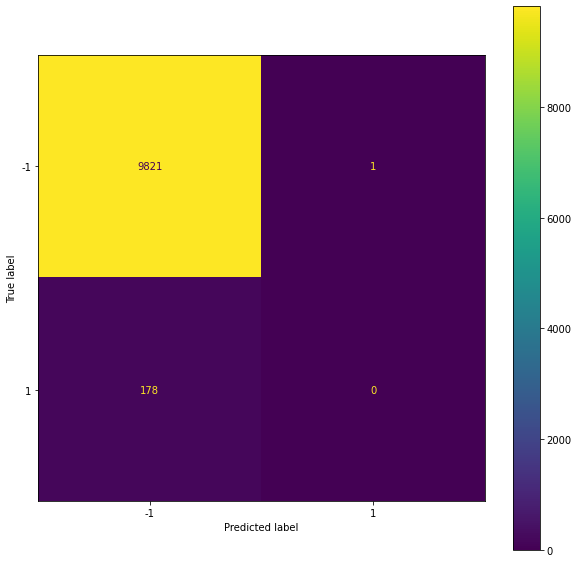

In [ ]:
## Decision Tree
dst, gs_dst = get_decision_tree(x_train, y_train.values.ravel())
predictions = dst.predict(x_test)
probabilities = dst.predict_proba(x_test)
final_result_appetency["decision_tree"] = get_metrics(predictions, y_test.values.ravel(), probabilities)

conf_matrix_appetency["decision_tree"] = get_confusion_matrix(y_test, predictions, dst.classes_)

No handles with labels found to put in legend.


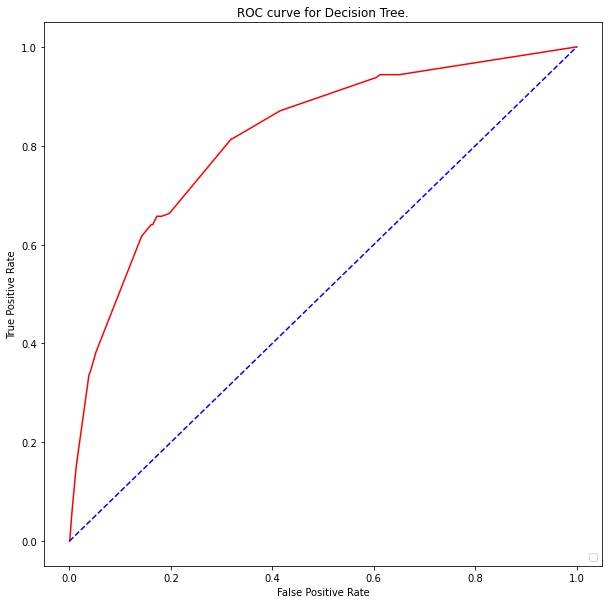

In [ ]:
## ROC Curve
roc_appetency["decision_tree"] = get_roc_curve(dst, x_test, y_test, "Decision Tree")

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 80, 'n_jobs': -1, 'oob_score': True, 'random_state': 0, 'verbose': 0, 'warm_start': False}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


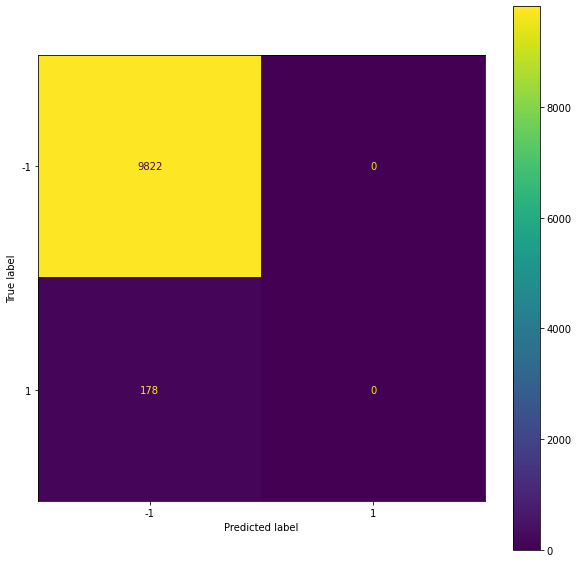

In [ ]:
## Random Vanilla Forest
rfv, gs_rfv = get_rf_vanilla(x_train, y_train.values.ravel())
predictions = rfv.predict(x_test)
probabilities = rfv.predict_proba(x_test)
final_result_appetency["vanilla_random_forest"] = get_metrics(predictions, y_test.values.ravel(), probabilities)

conf_matrix_appetency["vanilla_random_forest"] = get_confusion_matrix(y_test, predictions, rfv.classes_)

No handles with labels found to put in legend.


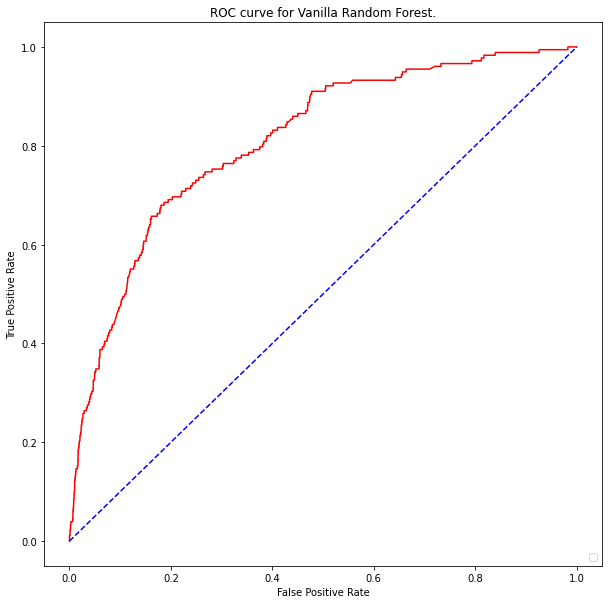

In [ ]:
## ROC Curve
roc_appetency["vanilla_random_forest"] = get_roc_curve(rfv, x_test, y_test, "Vanilla Random Forest")

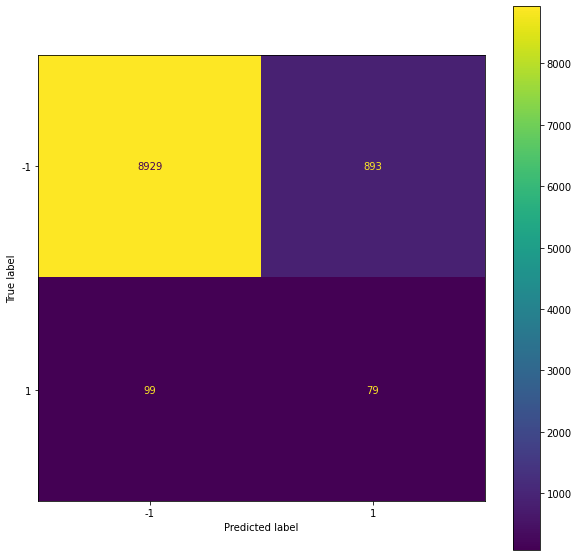

In [ ]:
## Random Forest with Balancing
rf_balance = get_rf_balance(x_train, y_train.values.ravel())
predictions = rf_balance.predict(x_test)
probabilities = rf_balance.predict_proba(x_test)
final_result_appetency["rf_balanced"] = get_metrics(predictions, y_test.values.ravel(), probabilities)

conf_matrix_appetency["rf_balanced"] = get_confusion_matrix(y_test, predictions, rf_balance.classes_)

No handles with labels found to put in legend.


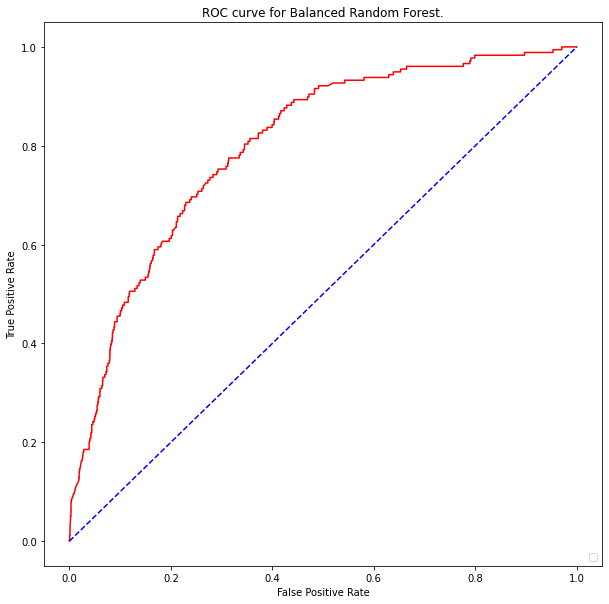

In [ ]:
## ROC Curve
roc_appetency["rf_balanced"] = get_roc_curve(rf_balance, x_test, y_test, "Balanced Random Forest")

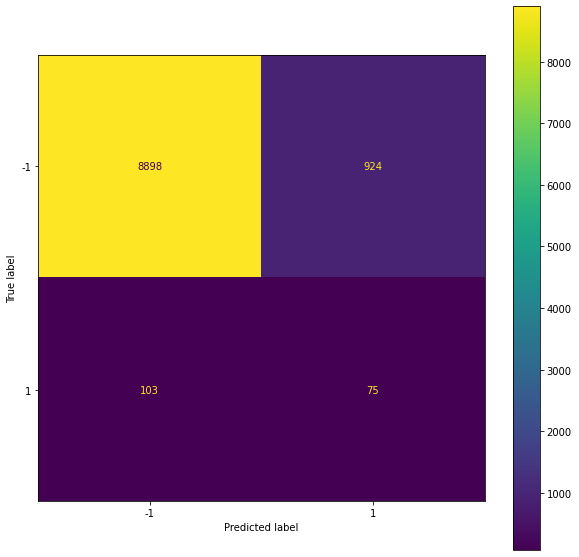

In [ ]:
## Random Forest with SMOTE resampling
rf_smote = get_rf_smote(x_train, y_train.values.ravel())
predictions = rf_smote.predict(x_test)
probabilities = rf_smote.predict_proba(x_test)
final_result_appetency["rf_smote"] = get_metrics(predictions, y_test.values.ravel(), probabilities)

conf_matrix_appetency["rf_smote"] = get_confusion_matrix(y_test, predictions, rf_smote.classes_)

No handles with labels found to put in legend.


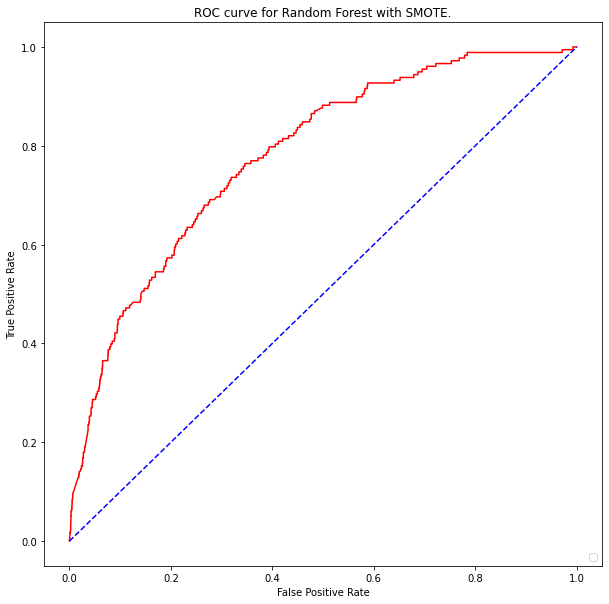

In [ ]:
## ROC Curve
roc_appetency["rf_smote"] = get_roc_curve(rf_smote, x_test, y_test, "Random Forest with SMOTE")

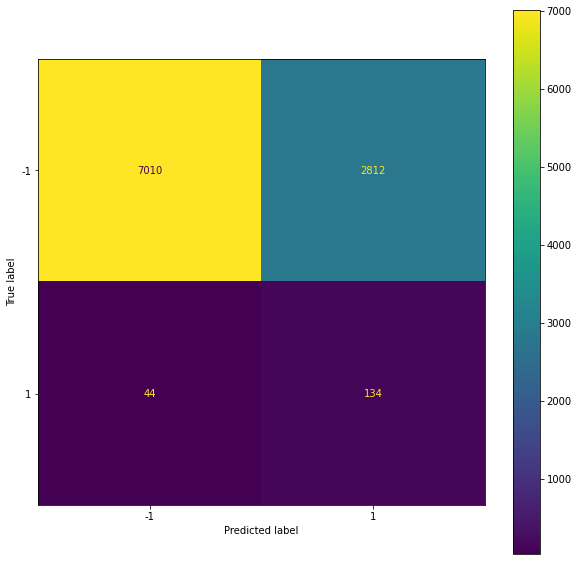

In [ ]:
## Random Forest with downsampling
rf_d = get_rf_downsampler(x_train, y_train.values.ravel())
predictions = rf_d.predict(x_test)
probabilities = rf_d.predict_proba(x_test)
final_result_appetency["rf_down"] = get_metrics(predictions, y_test.values.ravel(), probabilities)

conf_matrix_appetency["rf_down"] = get_confusion_matrix(y_test, predictions, rf_d.classes_)

No handles with labels found to put in legend.


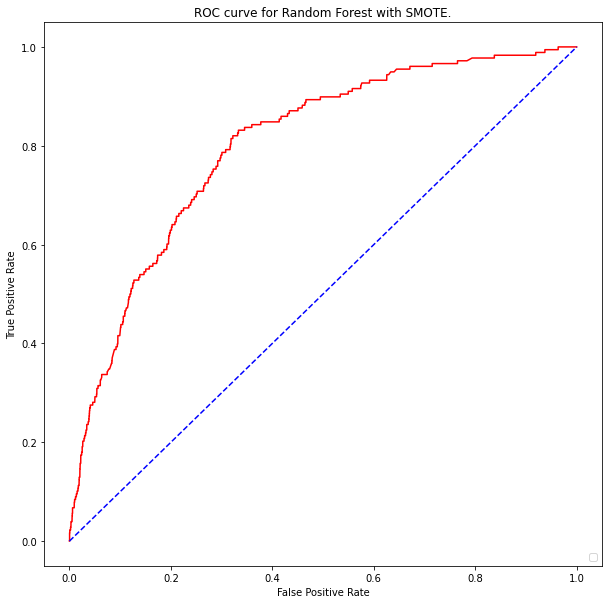

In [ ]:
## ROC Curve
roc_appetency["rf_down"] = get_roc_curve(rf_d, x_test, y_test, "Random Forest with SMOTE")

{'algorithm': 'SAMME', 'base_estimator__ccp_alpha': 0.0, 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 0.01, 'n_estimators': 20, 'random_state': None}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


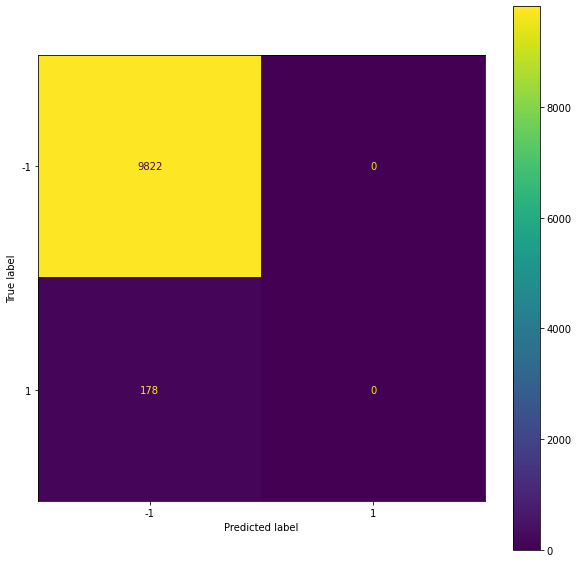

In [ ]:
## AdaBoost
ada, gs_ada = get_adaboost(x_train, y_train.values.ravel(), 'RECALL')
predictions = ada.predict(x_test)
probabilities = ada.predict_proba(x_test)
final_result_appetency["adaboost"] = get_metrics(predictions, y_test.values.ravel(), probabilities)

conf_matrix_appetency["adaboost"] = get_confusion_matrix(y_test, predictions, ada.classes_)

No handles with labels found to put in legend.


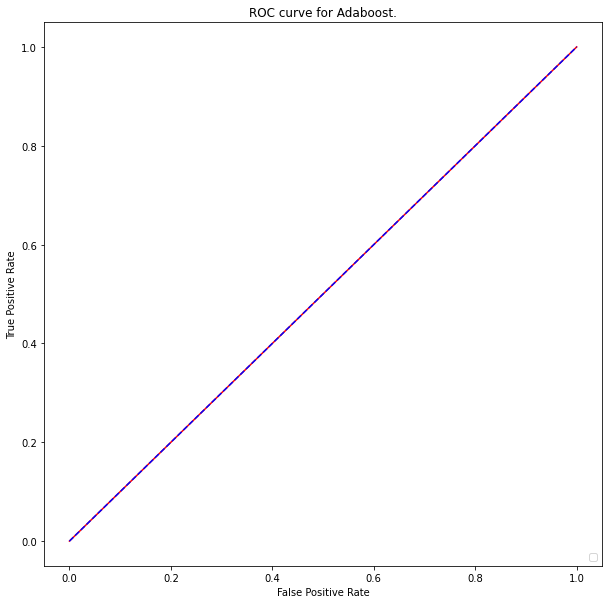

In [ ]:
## ROC Curve
roc_appetency["adaboost"] = get_roc_curve(ada, x_test, y_test, "Adaboost")

In [ ]:
print_metrics(final_result_appetency)

+-----------------------+----------+---------------------+----------------------+---------------------+--------------------+
|       Model Name      | Accuracy |        Recall       |      Precision       |       F1 Score      |     AUC score      |
+-----------------------+----------+---------------------+----------------------+---------------------+--------------------+
|       logic_reg       |  0.7305  |  0.7696629213483146 | 0.049086348978860626 | 0.09228696530818457 | 0.8187166965239694 |
|     decision_tree     |  0.9821  |         0.0         |         0.0          |         0.0         | 0.8177511960080444 |
| vanilla_random_forest |  0.9822  |         0.0         |         0.0          |         0.0         | 0.810392972437477  |
|      rf_balanced      |  0.9008  |  0.4438202247191011 | 0.08127572016460906  | 0.13739130434782612 | 0.8008191882931919 |
|        rf_smote       |  0.8973  | 0.42134831460674155 | 0.07507507507507508  | 0.12744265080713676 | 0.7805185103837065 |


In [ ]:
## The permutation importance for rf_down
get_permutation_importance(rf_balance, x_test, y_test, final_features)

Var208_kIsH0.000 +/- 0.000


**Predicting Churn**

In [ ]:
## Splitting the training data as there is no corresponding label file
## for orange_small_test.data
## Get the test train split with Upselling data
x_train, x_test, y_train, y_test = get_train_test_split(df_train, y_train_churn)

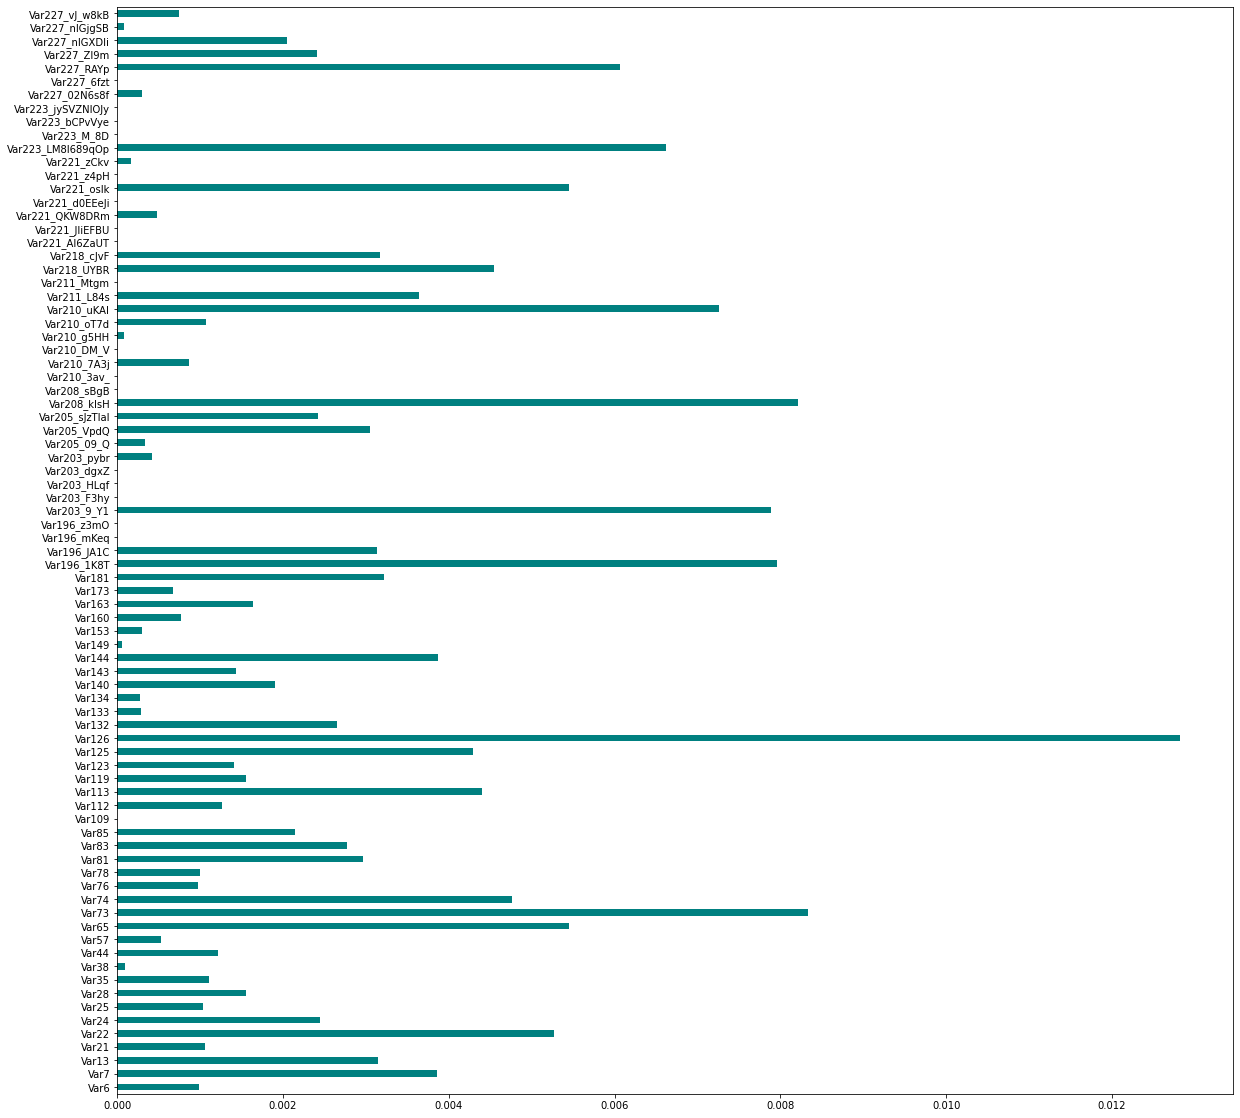

In [ ]:
## Compute information gain for features
ig_importances = mutual_info_classif(x_train, y_train.values.ravel())
feat_importances = pd.Series(ig_importances, df_train.columns)
ft_ig = feat_importances[feat_importances >= feat_importances.quantile(0.25)].index.tolist()

plt.rcParams["figure.figsize"] = (20,20)
feat_importances.plot(kind= "barh", color = "teal")

plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


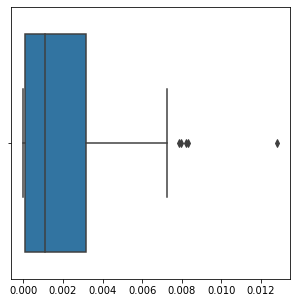

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)
sns.boxplot(feat_importances)

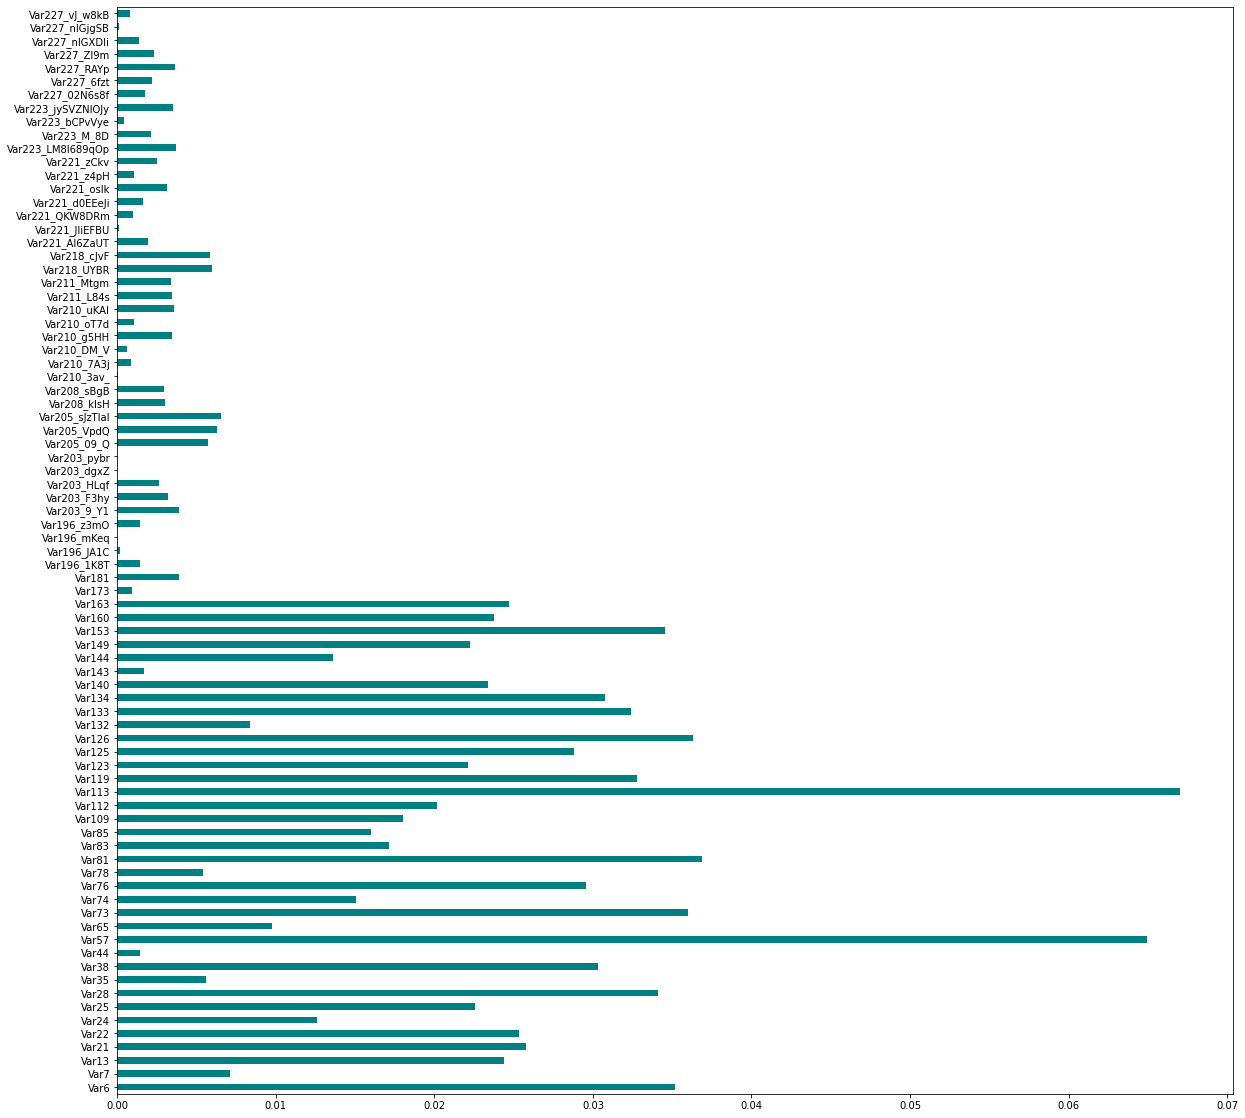

In [ ]:
## Random Forest Feature Importance
rf_feat_select = RandomForestClassifier(n_estimators=340)
rf_feat_select.fit(x_train, y_train.values.ravel())
rf_imp = rf_feat_select.feature_importances_
rf_importance = pd.Series(rf_imp, df_train.columns)

# Select all features above the 25th percentile
ft_rf = rf_importance[rf_importance >= rf_importance.quantile(0.25)].index.tolist()

plt.rcParams["figure.figsize"] = (20,20)
rf_importance.plot(kind= "barh", color = "teal")
plt.show()

In [ ]:
## Get the final list of important features based on Information Gain and RF importance
final_features = get_feature_intersection(ft_ig, ft_rf)
print(final_features)

['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25', 'Var28', 'Var35', 'Var38', 'Var57', 'Var65', 'Var73', 'Var74', 'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var112', 'Var113', 'Var119', 'Var123', 'Var125', 'Var126', 'Var132', 'Var133', 'Var134', 'Var140', 'Var143', 'Var144', 'Var153', 'Var160', 'Var163', 'Var181', 'Var203_9_Y1', 'Var205_09_Q', 'Var205_VpdQ', 'Var205_sJzTlal', 'Var208_kIsH', 'Var210_uKAI', 'Var211_L84s', 'Var218_UYBR', 'Var218_cJvF', 'Var221_oslk', 'Var221_zCkv', 'Var223_LM8l689qOp', 'Var227_02N6s8f', 'Var227_RAYp', 'Var227_ZI9m']


In [ ]:
## Reset the data frames based on the new final features
x_train = pd.DataFrame(x_train, columns=df_train.columns)
x_test = pd.DataFrame(x_test, columns=df_train.columns)

x_train = x_train[final_features].values
x_test = x_test[final_features].values

final_result_churn = {}
conf_matrix_churn = {}
roc_churn = {}

{'C': 0.1, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 5000, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


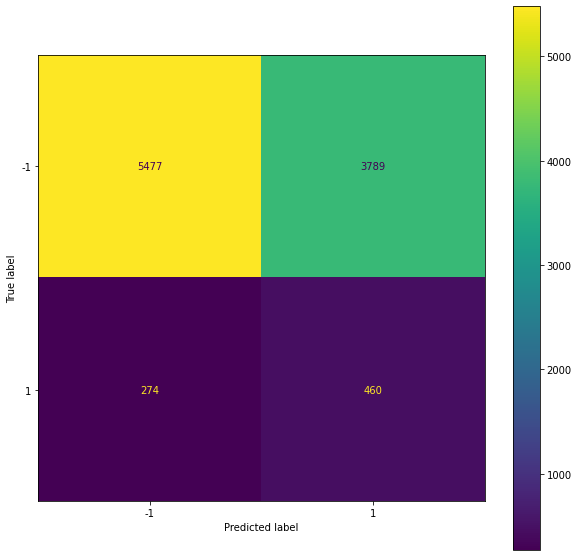

In [ ]:
## Logistic Regression
lreg, gs_lreg = get_logistic_regression(x_train, y_train.values.ravel())
predictions = lreg.predict(x_test)
probabilities = lreg.predict_proba(x_test)
final_result_churn["logic_reg"] = get_metrics(predictions, y_test.values.ravel(), probabilities)

conf_matrix_churn["logic_reg"] = get_confusion_matrix(y_test, predictions, lreg.classes_)

No handles with labels found to put in legend.


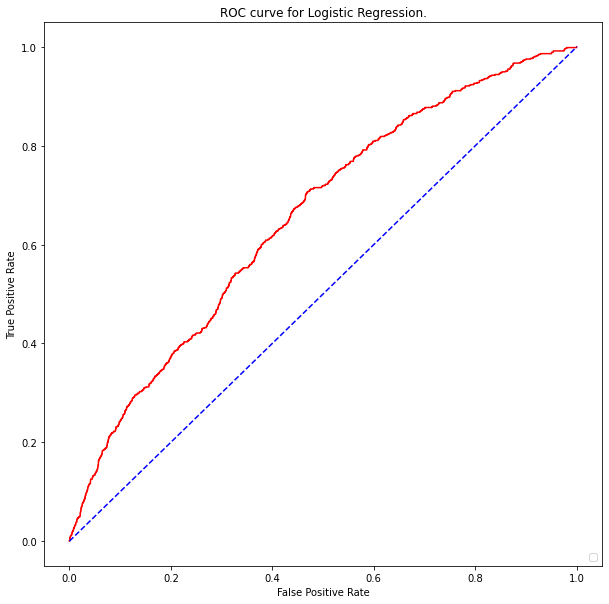

In [ ]:
## ROC Curve
roc_churn["logic_reg"] = get_roc_curve(lreg, x_test, y_test, "Logistic Regression")

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


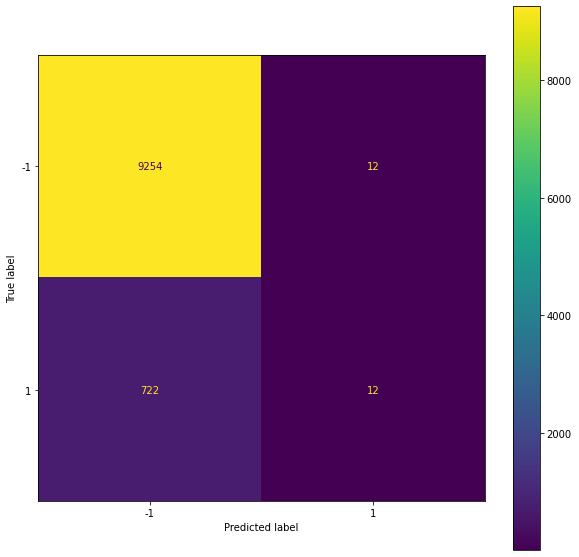

In [ ]:
## Decision Tree
dst, gs_dst = get_decision_tree(x_train, y_train.values.ravel())
predictions = dst.predict(x_test)
probabilities = dst.predict_proba(x_test)
final_result_churn["decision_tree"] = get_metrics(predictions, y_test.values.ravel(), probabilities)

conf_matrix_churn["decision_tree"] = get_confusion_matrix(y_test, predictions, dst.classes_)

No handles with labels found to put in legend.


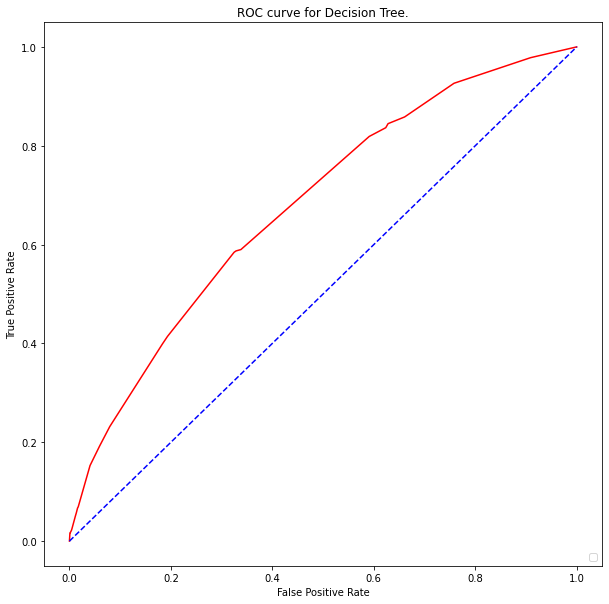

In [ ]:
## ROC Curve
roc_churn["decision_tree"] = get_roc_curve(dst, x_test, y_test, "Decision Tree")

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'random_state': 0, 'verbose': 0, 'warm_start': False}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


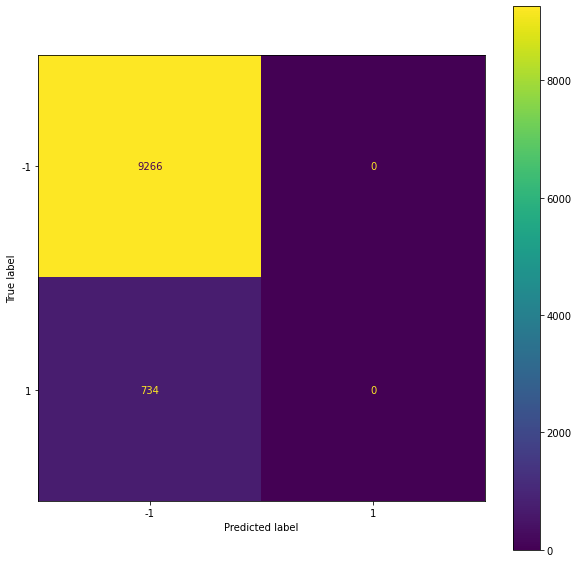

In [ ]:
## Random Vanilla Forest
rfv, gs_rfv = get_rf_vanilla(x_train, y_train.values.ravel())
predictions = rfv.predict(x_test)
probabilities = rfv.predict_proba(x_test)
final_result_churn["vanilla_random_forest"] = get_metrics(predictions, y_test.values.ravel(), probabilities)

conf_matrix_churn["vanilla_random_forest"] = get_confusion_matrix(y_test, predictions, rfv.classes_)

No handles with labels found to put in legend.


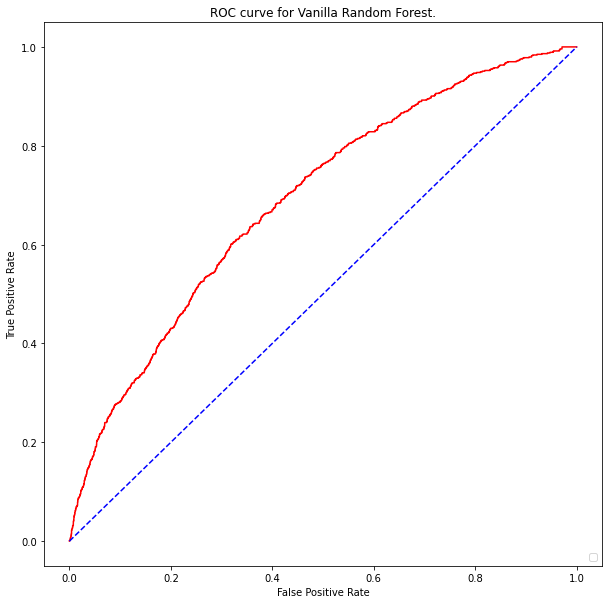

In [ ]:
## ROC Curve
roc_churn["vanilla_random_forest"] = get_roc_curve(rfv, x_test, y_test, "Vanilla Random Forest")

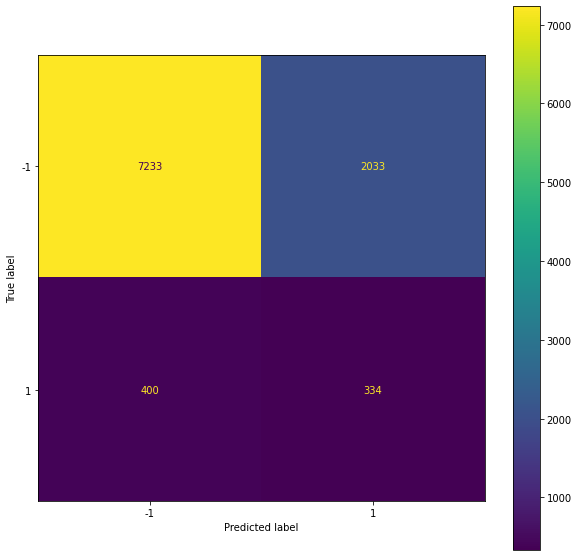

In [ ]:
## Random Forest with Balancing
rf_balance = get_rf_balance(x_train, y_train.values.ravel())
predictions = rf_balance.predict(x_test)
probabilities = rf_balance.predict_proba(x_test)
final_result_churn["rf_balanced"] = get_metrics(predictions, y_test.values.ravel(), probabilities)

conf_matrix_churn["rf_balanced"] = get_confusion_matrix(y_test, predictions, rf_balance.classes_)

No handles with labels found to put in legend.


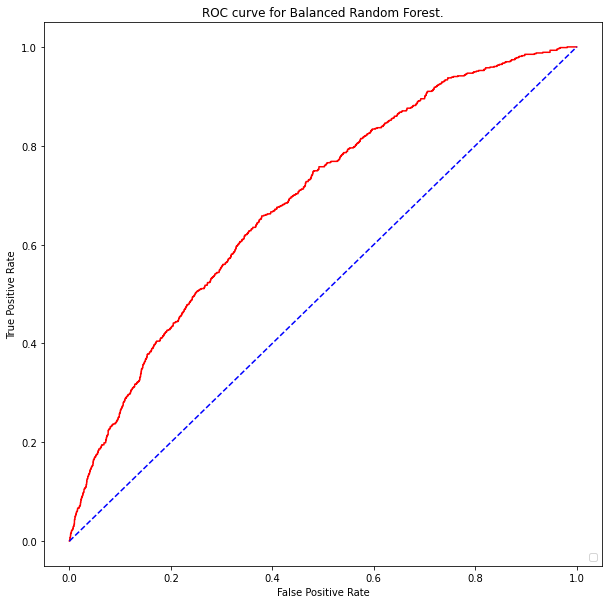

In [ ]:
## ROC Curve
roc_churn["rf_balanced"] = get_roc_curve(rf_balance, x_test, y_test, "Balanced Random Forest")

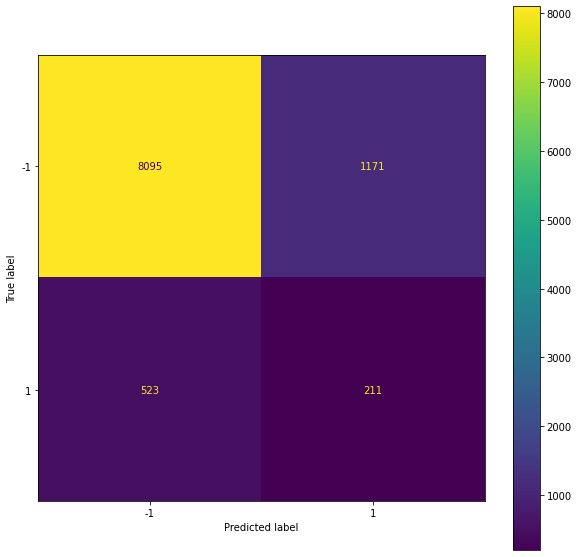

In [ ]:
## Random Forest with SMOTE resampling
rf_smote = get_rf_smote(x_train, y_train.values.ravel())
predictions = rf_smote.predict(x_test)
probabilities = rf_smote.predict_proba(x_test)
final_result_churn["rf_smote"] = get_metrics(predictions, y_test.values.ravel(), probabilities)

conf_matrix_churn["rf_smote"] = get_confusion_matrix(y_test, predictions, rf_smote.classes_)

No handles with labels found to put in legend.


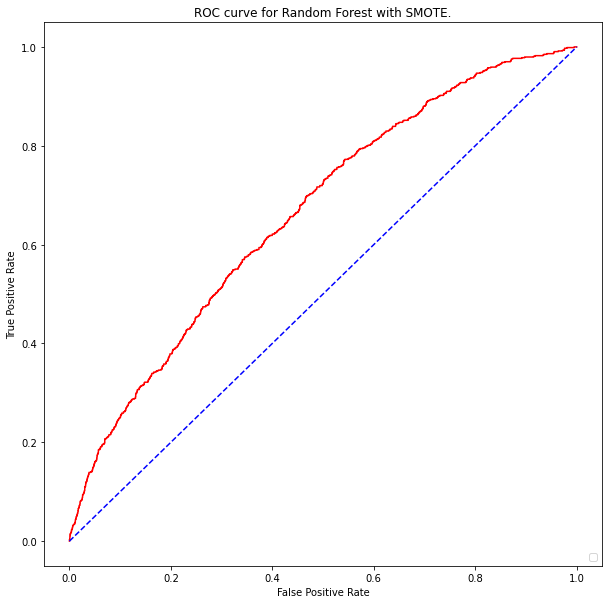

In [ ]:
## ROC Curve
roc_churn["rf_smote"] = get_roc_curve(rf_smote, x_test, y_test, "Random Forest with SMOTE")

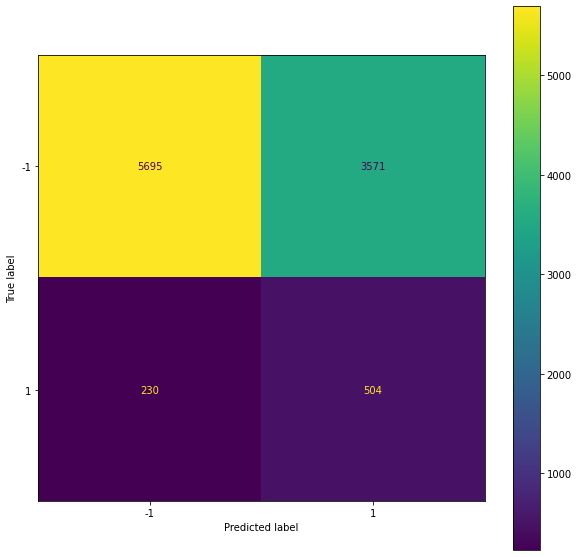

In [ ]:
## Random Forest with downsampling
rf_d = get_rf_downsampler(x_train, y_train.values.ravel())
predictions = rf_d.predict(x_test)
probabilities = rf_d.predict_proba(x_test)
final_result_churn["rf_down"] = get_metrics(predictions, y_test.values.ravel(), probabilities)

conf_matrix_churn["rf_down"] = get_confusion_matrix(y_test, predictions, rf_d.classes_)

No handles with labels found to put in legend.


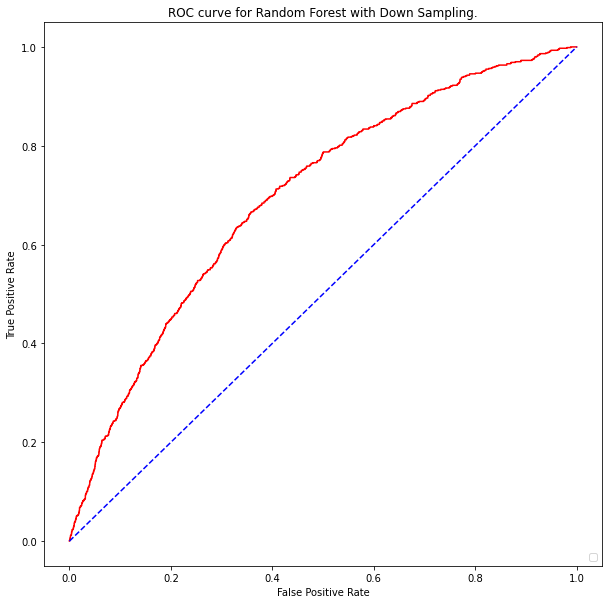

In [ ]:
## ROC Curve
roc_churn["rf_down"] = get_roc_curve(rf_d, x_test, y_test, "Random Forest with Down Sampling")

{'algorithm': 'SAMME', 'base_estimator__ccp_alpha': 0.0, 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 1, 'n_estimators': 40, 'random_state': None}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


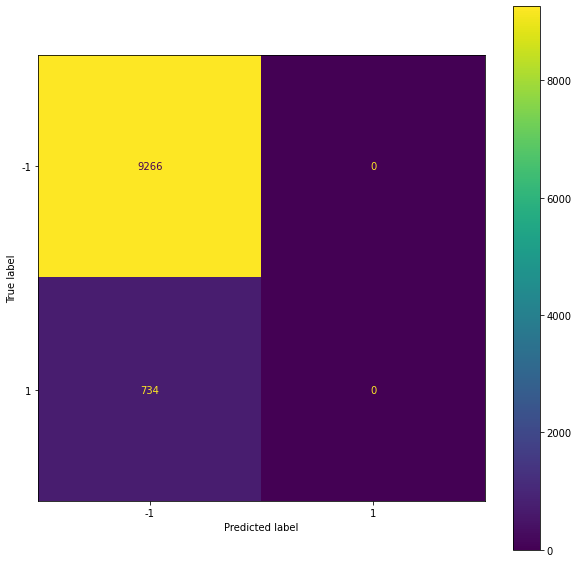

In [ ]:
## AdaBoost
ada, gs_ada = get_adaboost(x_train, y_train.values.ravel())
predictions = ada.predict(x_test)
probabilities = ada.predict_proba(x_test)
final_result_churn["adaboost"] = get_metrics(predictions, y_test.values.ravel(), probabilities)

conf_matrix_churn["adaboost"] = get_confusion_matrix(y_test, predictions, ada.classes_)

No handles with labels found to put in legend.


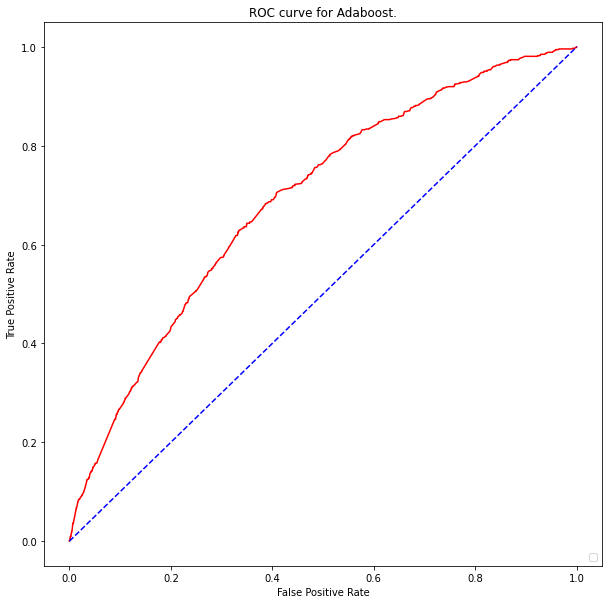

In [ ]:
## ROC Curve
roc_churn["adaboost"] = get_roc_curve(ada, x_test, y_test, "Adaboost")

In [ ]:
print_metrics(final_result_churn)

+-----------------------+----------+---------------------+---------------------+----------------------+--------------------+
|       Model Name      | Accuracy |        Recall       |      Precision      |       F1 Score       |     AUC score      |
+-----------------------+----------+---------------------+---------------------+----------------------+--------------------+
|       logic_reg       |  0.5937  |  0.6267029972752044 | 0.10826076723935044 | 0.18462773429660848  | 0.6544302777550695 |
|     decision_tree     |  0.9266  | 0.01634877384196185 |         0.5         | 0.031662269129287594 | 0.6783559742894095 |
| vanilla_random_forest |  0.9266  |         0.0         |         0.0         |         0.0          | 0.6905298501274179 |
|      rf_balanced      |  0.7567  |  0.4550408719346049 | 0.14110688635403465 | 0.21541438245727187  | 0.6876650800941709 |
|        rf_smote       |  0.8306  | 0.28746594005449594 | 0.15267727930535455 | 0.19943289224952743  | 0.6637738625463224 |


In [ ]:
## The permutation importance for rf_balance
get_permutation_importance(rf_balance, x_test, y_test, final_features)

Var126  0.022 +/- 0.002
Var218_UYBR0.002 +/- 0.001
Var143  0.000 +/- 0.000
